## Ch.3 - *Investigating organic carbon respiration as a driver for highly negative $\delta^{13}$C$_{carb}$ values during the Shuram excursion: heterogeneous TOC fluxes along a shelf-to-slope transect*

##### Connor van Wieren, 2025

In [1]:
todays_date = str(datetime.now())[:16] # lim  it to minutes`
display(Markdown(f'##### Date: {todays_date}'))
print(f'detected theme = {current_theme}')
#plt.style.use(light_style) 
#plt.style.use(dark_style)

##### Date: 2025-07-24 10:03

detected theme = light


## Imports and paths

In [2]:
import pandas as pd
from tqdm.notebook import tqdm
import jax
import jax.numpy as jnp
from jax import  jit, random, lax, vmap
from jax.scipy.integrate import trapezoid as trapz
jax.config.update('jax_platform_name', 'cpu')
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib
import matplotlib.ticker as ticker
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib.patches as patches
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns
import pandas as pd 
import time
import os
from scipy import signal
from scipy.stats import norm, uniform, gaussian_kde
from scipy.ndimage import uniform_filter1d
from scipy.ndimage import gaussian_filter
from scipy.stats import spearmanr
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import rasterio
import pickle
import dill
import sys
import string

matplotlib.rcParams['pdf.fonttype'] = 42  # for acrobat? idk why i need this

# load funcs from .py files
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/sed_transport/sed_transport')
from model_dev import run
from utils import *
from output import Model_output

# import facies
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/code/')
from facies import facies

# interactive plots
from ipywidgets import interactive, interact
from IPython.display import clear_output, Video

#np.set_printoptions(threshold=np.inf,linewidth=np.inf)
sns.set_context('paper')

# figures
fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/shuram_TOC/figures/'
tex_fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/PhD/Ch3_Shuram_TOC_geology/img/'

## To Do:
1. [ ] Task

## Organic Matter Production
- Organic matter is primarily produced in surface waters through primary productivity, so at a first order, is spatially similar over both the shelf (closer to shore/shallower water column) and the slope (farther from shore/deeper water column)
- However, processes such as marine energy (waves etc.), ambient sedimentation rates, and the presence/absence of oxygen strongly modulate the preservation of organic matter.
- Higher energy makes it harder to preserve organic matter, and sedimentation rate can dilute and change how much is preserved. Highly oxygenated environemnts will lead to higher respiration rates quickly remineralizing the organic matter. Anoxic or suboxic environments will allow for the organics to preserve best
- sedimentation rates (e.g. from river input) and oxygen concentrations are commonly higher in shelf settings and thus preservation rates are higher off-shore on the slope, also bioturbation/oxygenation higher on shelf
- see *Ganeshram et al., 1999* for good discussion of locations that have higher TOC preservation
- Maybe organize with somethign like this with 4 unique zones:

| Zone        | Production | Reworking | Preservation  | TOC Accumulation |
|-------------|------------|-----------|---------------|------------------|
| Inner shelf | High       | High      | Low           | Low–moderate     |
| Outer shelf | Moderate   | Moderate  | Moderate      | Moderate         |
| Slope       | Moderate   | Low       | High          | High             |
| Basin       | Low        | Low       | Variable      | Variable         |

## Goals:
- Use first model run to calculate where/how much TOC is accumulating, and how much is respired
- Use second model to react/alter d13c_carb based on the TOC respired in model 1 and advect the altered quantity around
- Want to ultimately test how TOC respiration controls $\delta^{13}C_{carb}$ along a shelf-to-slope transect (see Busch et al., 2022; Shuram)
- both model runs use the same topography (carbonate + organics)

## First principles ideas based on first figure I made:
- Possible avenue could be to see what d44Ca looks like in these places (can look at anne-sofie or ahliahs data) for bahamas or great barrier reef to comprare. where do we see shifts. In my plot, the red bands would be close to 0‰ and the yellow closer to -1 to -1.5‰ if no advection
- In the test I did (d13c_sw = 0‰ and d13c_sed = 1‰) kinda similar to an aragonite to calcite conversion with depth
- To address problem with scale, we want to first make sure my dx and dy scales are realistic, and same for lengthscale of diagenesis
	- after this, we can do an integral (np.trapz(array,dy), where dy is my grid dy) this should make sharp changes in my curve more obvious. right now, with the downsample grid, it is not as smooth, and probably why i have to use such a gradual curve and low f_react
-  Bottom value of exponential: want it to be the average of lower stratigraphy. otherwise we are saying it is closer to seawater, which is not true. want it to be more like evolved sediment
	- could have some function that just calculates average rock value below a certain depth (10m of rock, masked to be below SWI by some margin)
 - Jon says that for a reviewer or someone, the $w$ value representing organic carbon concentrations shuold really be TOC or percent organic carbon which will need to be normalized to grid size
 - Wonoka doesn’t have a shelf to slope transect, but can use things like busch for a more global theoretical transect, which again, is more broad
 - Blake noticed how in the Doushantuo dataset (Wang et al., 2016), there is sections that have exposure surfaces etc. with excursion rising/falling limbs that go below the surface, my last paper would predict a sharp jump and this is gradual and incompatible with my model, could be explained by diagenesis, could be something in the discussion

## Shuram major patterns
1) the shelf-slope transect patterns (Busch)
2) the simple observations of e.g. fike, highly negative at deep water deposition, near monotonic slow recovery in shallow
3) old model style would require a crazy large gradient in seawater dic, so what else is needed
4) Want to generate tuye full $\delta^{13}C_{carb}$ range observed for the Shuram
5) Think about how downturn of excursion is in transgressive, but regressive sea level fall during recovery (see Wonoka which is all regressive, mfs is far below)
6) How can we make such patterns only varying TOC

## Ideas:
1) Create a bunch of spatially heterogeneous organic matter (TOC)
2) At each location, a reaction profile below SWI controls the respiration of TOC. Create organic matter, remineralize a fraction of it, and scale that to the porefluid scale
3) Calculate how $\delta^{13}C_{carb}$ changes in response to this
4) Are there places where organic concentration stay shigh and react over a long duration?
5) In modern sediments, slope settings have light $\delta^{13}C_{carb}$ (~-5‰) and high variance (even matthews data) lots of papers, just need to find one
6) How can we push such forcings in a sequence stratigraphic framework to create highly negative CIE’s like the Shuram beyond -5‰ (making $\delta^{13}C_{carb}$ excursions in organic-rich margins)
7) Maybe landward of major $\delta^{13}C_{carb}$ excursions, $\delta^{44}Ca_{carb}$ changes? where would these changes be found in the basin
8) Can apply to oehlert organic-inorganic covariance paper
9) look at dataset for relationship between sed rate and TOC (Hedges, keele, older papers on organic carbon accumulation)
10) how can we get highly negative at base of transgression, normal at top without huge spatial d13c_dic gradient
11) $\Delta^{13}C$ decoupling will probably be higher at the locations highlighted by my first simple diagenesis test figure. Think about the relationships to surfaces


## Potential Discussion Points
1)  simplified version of d13c_org and could be compared via cross plots to Wang 2016 dataset; “this shows how sediments fall off of the 1:1 dic line”/”here is how the TOC compares with d13c deviations from DIC
2)  Easier to say that if no variation in DIC/d13c_carb, should expect these relationships in these locations (example discussion point)
3)  A major figure could be a conservative vs non-conservative proxy cross-plot
	- in the paper, would really be d13c_carb (non-conservative) vs d13c_org (conservative) and say, these could be what the conservative/nonconservative parts are

## Assumptions
1) Infinite reservoir of fluid at sediment-water-interface ($SWI$); hence most accurate curve reaction near or at SWI
2) $\delta^{13}C_{org}$ $\approx$ $\delta^{13}C_{DIC}$ (in absence of diagenesis or multiple organic carbon sources); essentially we are using organic carbon isotopes as metric of dissolved inorganic carbon ($DIC$) (simplified d13c_org is really the residual between d13c_carb, and version of model run without diagenesis minus $\epsilon_p$ , will show the same thing)

## Variables
1) Total Organic Carbon (wt% $TOC$); **variable mass flux (spatially heterogeneous)** $\rightarrow$ *think about where to make higher/lower*
2) Sedimentation rate: should have a strong control of organic matter preservation
3) Carbon isotopes of carbonate ($\delta^{13}C_{carb}$ = 0‰ or 6‰ or something); **Constant for inital model (only modulator is respiration)**
4) Photosynthetic fractionation factor ($\epsilon_p \approx -25‰$)
5) Carbon isotopes of organic matter ($\delta^{13}C_{org}$); **Constant related to DIC as $\delta^{13}C_{org} \approx \delta^{13}C_{carb} - \epsilon_p$**
6) Reaction percentage per timestep for the alteration of $\delta^{13}C_{carb}$ precipitated from pore fluids altered by respiration; **can be variable as well but maybe rate below this would be enough** (e.g. 1% reaction per timestep or something)
7) Reaction percentage per timestep for the amount of TOC respired per timestep; **can be variable as a measure of respiration rates**
8) Sea level (need at least major transgression and regression for Shuram)
9) Shape of porefluid curve

## Input Curves and which model they are applied in
1) Model 1: TOC Burial and Respiration loss **(conservative tracer model)**
    - TOC Concentration profile, the amount of TOC as a function of depth
    - TOC Decay Fraction Curve: A curve describing the fraction of TOC that is respired as a function of depth
    - Respired TOC Profile: The actual amount of TOC lost to respiration at each depth
2) Model 2: Diagenesis and $\delta^{13}C_{carb}$ reaction **(non-conservative tracer model)**
    - Porefluid $\delta^{13}C_{DIC}$ profile: The $\delta^{13}C$ of the porefluid at depth due to mixing of respired TOC (typically −25‰) with seawater DIC
    - Reaction Curve: Optional. Fraction of carbonate that re-equilibrates with porefluid at each depth. If only partial exchange occurs with porefluid (as in model version now for simple diagenesis)
3) Model 3: No diagenesis **(conservative tracer)** version for discussion comparision

## Code implementation
- Could maybe do with one w in model, and run twice
- We have one model that just tracks the mass of organic carbon derived from rainout. basically a qh_org that adds onto the carbonate, and we track how much is remineralized.; tracks org h and carb h, same topography
    - i.e. maybe we lose 1% of organic carbon per timestep, but that decay rate changes with depth, i.e. fresh organic matter decays faster than older?
- the second model run takes the full output of the first model as an input so it can be used, and then calculates d13c pore fluid curves and changes to d13c_carb
- Basically have three curves. One that is the conversion of TOC to remineralized amount (how much is lost) and the difference in this toc remineralization rate can be non-constant and decay with depth. This difference is used to make. some curve of organic remineralization with depth changes this. this curve should be in similar structure to our diagenetic reaction curve, and take the difference between the TOC remineralization as input
- then from the organic respiration curve, we calculate a pore fluid d13c curve which is used to influence d13c_carb

## References
1)

# Model 1: TOC Remineralization
- want to run with full topography, including both carbonates and organics

Text(0.5, 0, 't')

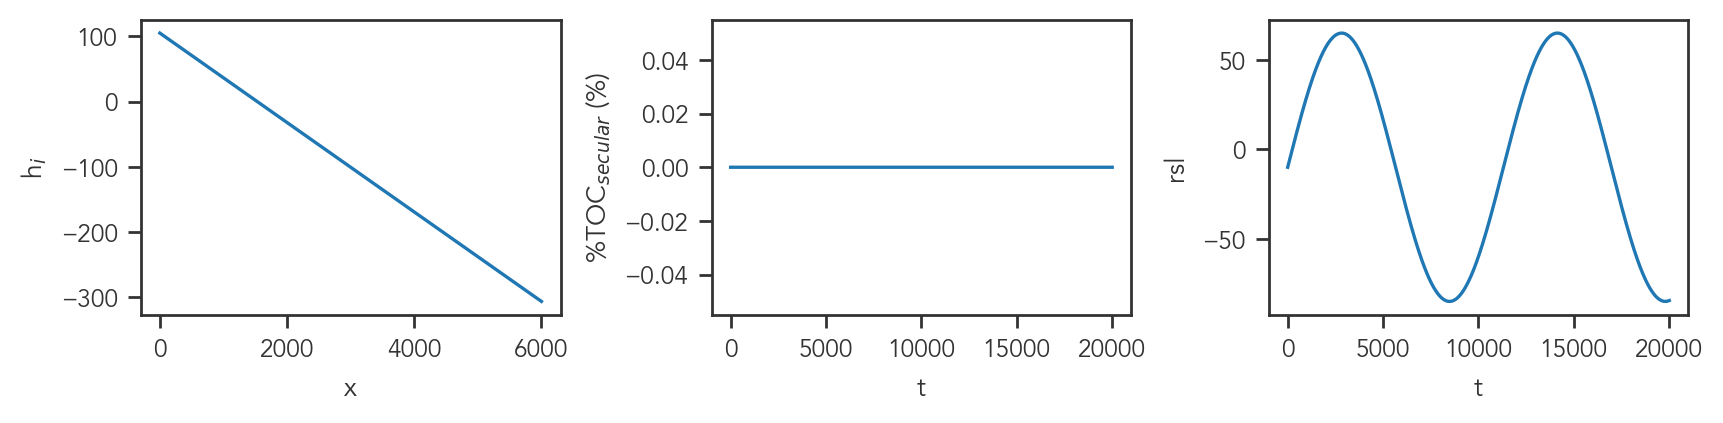

In [3]:
# from the current method
p1 = {'Nx':400,       
      'xmin':0,
      'xmax':6000,     
      'dx':0.8,
      'start':0,
      'dt':0.1,
      'total_n':2000,
      'compiled_steps':100,
      'ep':-25,
      'org_epsilon': 0,
      'pel_epsilon':0,
      'alg_epsilon':0, 
      'coral_epsilon':0,
      'ocean_depth':0,  
      'org_coef':0.0833/2, # 0.25
      'alg_coef':3.5, # 8.5  
      'marine_K':2.5e-1,   
      'land_K':5e-1,   
      'smooth_K':6,      
      'grid_ylen':1000,       
      'A':0.1,
      'f_react':0.00001,
      'tau':0.033,
      'base_depth':10}        

x,t,end = init_vars(p1)

# secular w array - want no change here
seawater = 0 # % TOC
sec_w_fun = lambda t: jnp.ones_like(t) * seawater

## Define h: initial topographic composition
hi = -0.0685*x+105

fig,ax = plt.subplots(1,3,figsize=(8.5,2),layout='constrained')

# initial proxy and topography
ax[0].plot(x,hi,label='h$_i$')
ax[0].set_xlabel('x')
ax[0].set_ylabel('h$_i$')

# proxy over time
ax[1].plot(t,sec_w_fun(t))
ax[1].set_ylabel(r'%TOC$_{secular}$ (%)')
ax[1].set_xlabel('t');

# sea level
sl_fun = lambda t: 75*jnp.sin((t)/1800)-10 # from EPSL paper
#sl_fun = lambda t: jnp.ones_like(t)*65 # constant sea level for testing

ax[2].plot(t,sl_fun(t))
ax[2].set_ylabel('rsl')
ax[2].set_xlabel('t')

## 1) Carbonate Production
- it actually might be easier to add all production into one larger function (like rename carbonate_growth to sediment_prod), and have organic in there for proper weighted averaging)

## 2) Organic Production
- I think it makes the most sense to also do a depth-based curve here, as can scale this easily in-model to have a shore/deep bias
- want to really model the preservation here, not just the production as there are many complex water column processes we don't want to model
- when scaling by sedimentation rate (high TOC preservation ~ areas of high carbonate growth) the band of high TOC follows maximum growth, makes sense. Patterns switch to match the below curve when that scaling factor is turned off
- I added a Dt in carbonate so that a shelf forms, but with current sed_rate scaling it means no organics grow on shelf. fix this

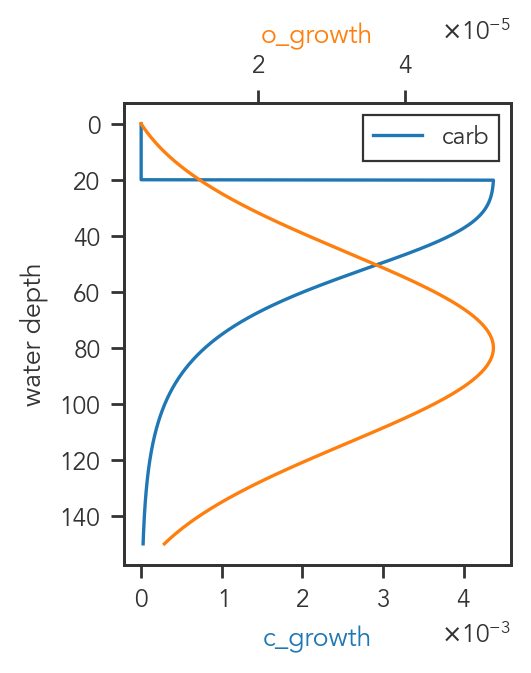

In [4]:
z = np.linspace(1e-5,150,1000)
# #carb_growth = lambda x: bosscher_G(x,Gm=0.00125,out='growth',Dt=0)
# # add a Dt tidal depth so that a submerged shelf happens
Dt = 20
#Dt = 0
carb_growth = lambda x: bosscher_G(x,Gm=0.00125,out='growth',Dt=Dt,k=0.05,Ik=200)

#org_growth = lambda x: bosscher_G(x,Gm=0.00125,out='growth',Dt=0)
org_growth = lambda x: erf_G(x, Gmax=0.00125, peak_width=55, G_depth=80)

fig,ax = plt.subplots(figsize=(2.5,3))
ax.plot(carb_growth(z)*p1['alg_coef'],z,label='carb')
axi = ax.twiny()
axi.plot(org_growth(z)*p1['org_coef'],z,label='org',color='tab:orange')
ax.set_xlabel('c_growth',color='tab:blue')
axi.set_xlabel('o_growth',color='tab:orange')
ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
axi.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
axi.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax.set_ylabel('water depth')
ax.invert_yaxis()
ax.legend()


### Run (1a): Grow TOC *without* loss to respiration

In [5]:
# initial sediment proxy
wi1 = jnp.ones_like(hi)*0.0
scale_organics = True

calculated ymin,ymax = -391.00, 190.00
mean grid dy = 5.816e-01


running model: TOCM1a_A0.1_ylen1000_2025-07-24 10:03:   0%|          | 0/2000 [00:00<?, ? compiled steps/s]

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.72e-01; mean deposited distance = 5.57e-02


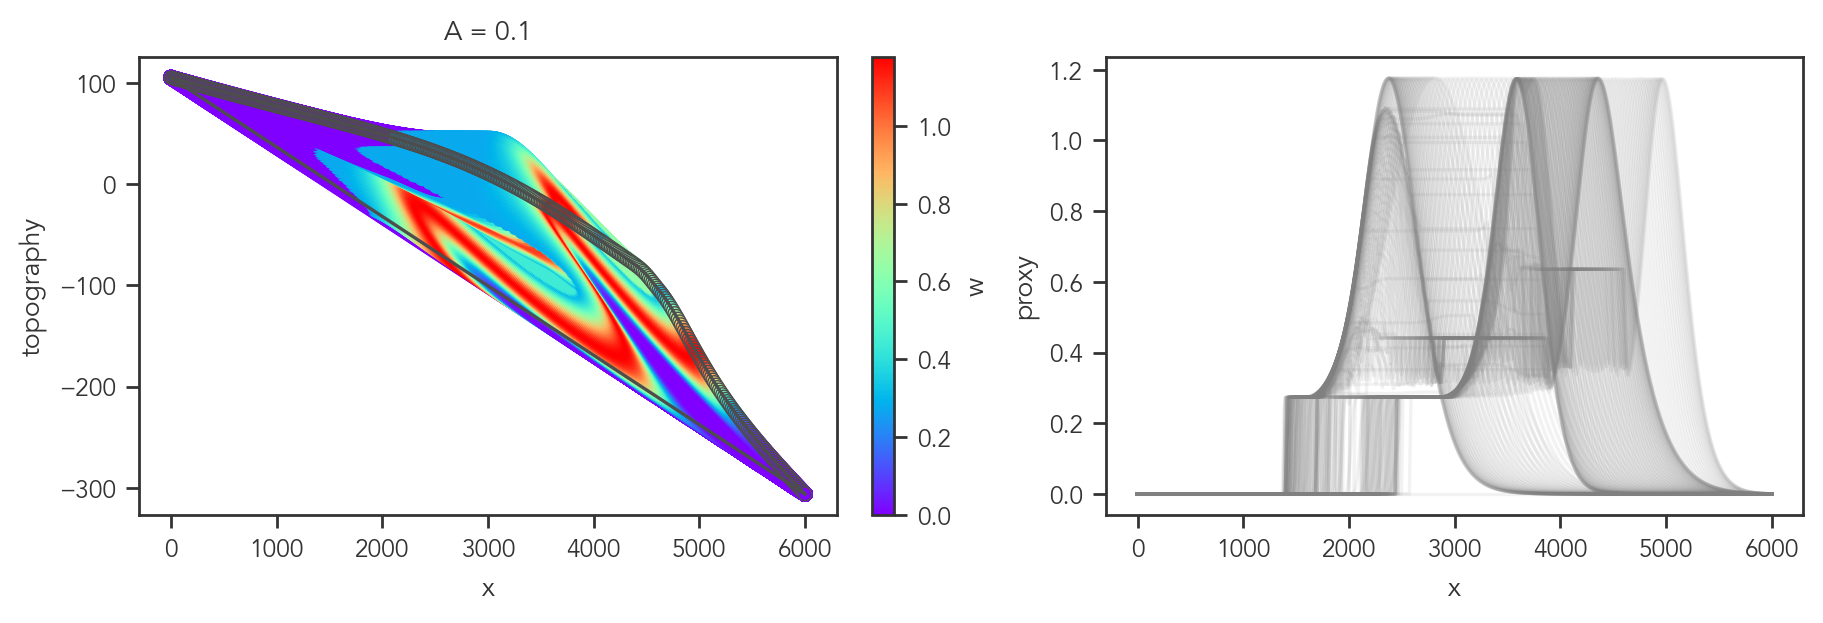

In [6]:
# run model
m1a = run(p1,                            
          model_desc = 'TOCM1a',                
          hi = hi,                            
          wi = wi1,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,           
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,                
          track_toc = True,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          swi_dist_calc = False,
          track_react = 'respiration',
          swi_fun = None)

im_ylen = 1000 matching grid_ylen


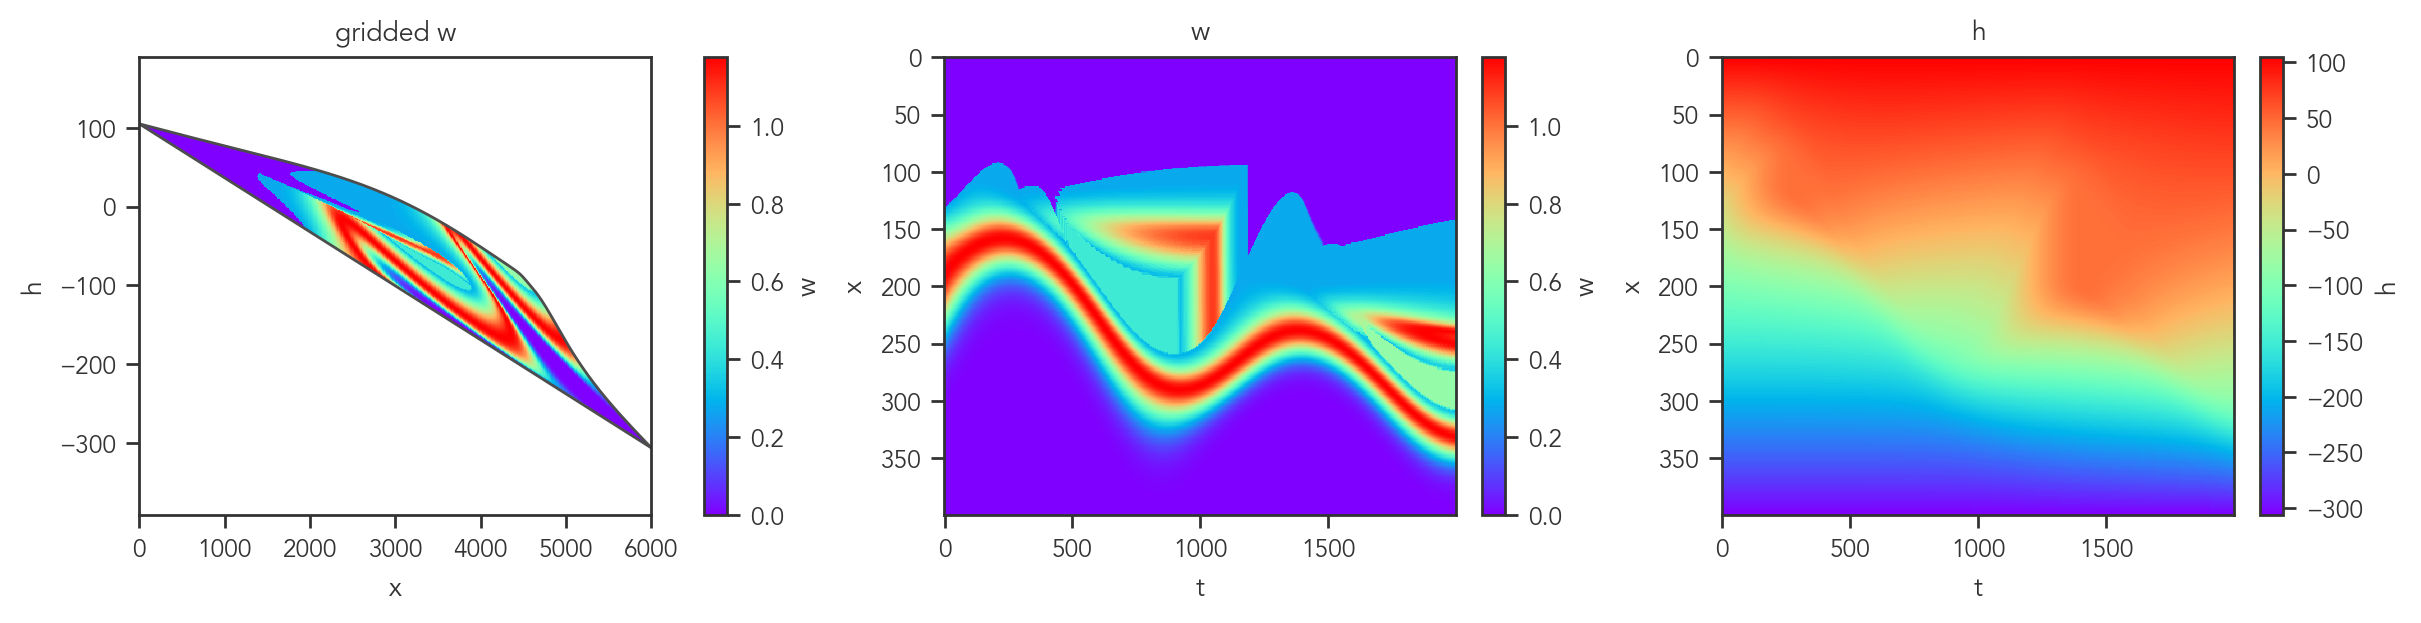

In [7]:
# simple version with fewer facies and just depth ranges
facies_data = facies(np.nanmax(m1a['ds']))

# facies colours # my_pal
facies_colours = list(sns.color_palette('BrBG',n_colors=len(facies_data)+1).as_hex()) # add one as going to drop the white one
facies_colours.pop(5) # drop the white one # was 4
#facies_colours[0] = '#C2461F'
sns.color_palette(facies_colours) # look at the palette

## model outputs
o1a = Model_output(**m1a,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=False)
o1a.plot_grids(cmap='rainbow')

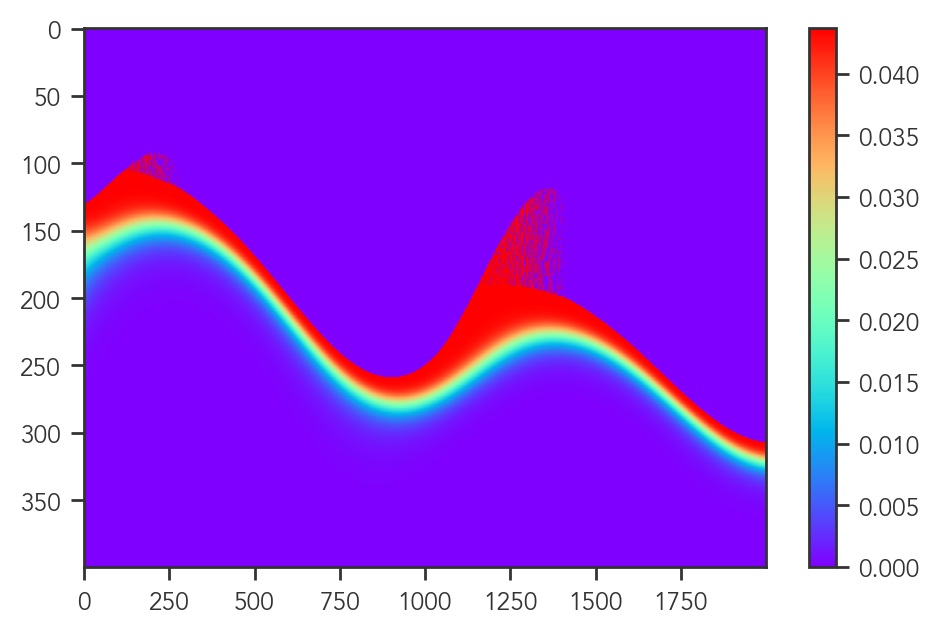

In [8]:
plt.imshow(o1a.csed_sto,aspect='auto',cmap='rainbow')
plt.colorbar()

## 3) Organic Respiration (Reaction Curve)

### Run (1b): Grow TOC *with* loss to respiration (see porosity profile in Berner)

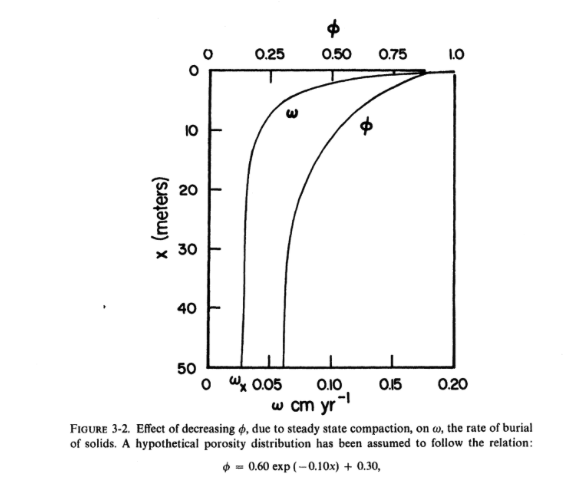

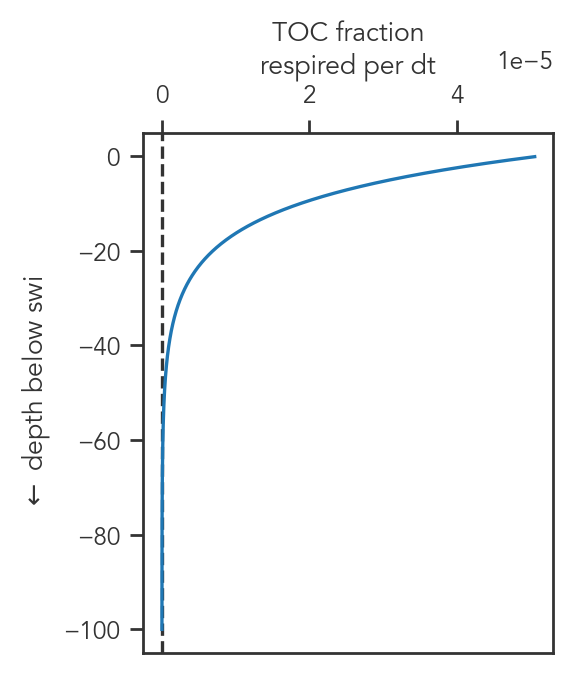

In [9]:
trg1 = 40 # % / Myr
R0 = compute_f_react(trg1, p1['dt']) # 40% / Myr
p1['f_react'] = R0 #0.00005 
p1['tau'] = 0.1 # how steep is curve for reaction; matches Fig 3.2 Berner porosity profile; more respiration in areas with more porespace
#p1['tau'] = 0.75 # how steep is curve for reaction; matches Fig 3.2 Berner porosity profile; more respiration in areas with more porespace

zs = np.arange(-100, 0, 0.1)

# for future reference: inside model code, the swi_fun/decay_fun must use these kwargs and best to use this format
# matches Berner porosity profile exactly with tau = 0.1; except i have scaled it to appraoch zero with depth
#### Need to make sure that f_react is not applied directly here and that these always are 0 to 1 so that the scaling within the model works correctly
def resp_fun(vertical_distance, d13c_seawater=1.0, base_value=0.0, tau=0.1, f_react=0.1):
    curve = (d13c_seawater * jnp.exp(tau * vertical_distance) +
             base_value * (1.0 - jnp.exp(tau * vertical_distance))) #+ 0.3 # can add this to match berner exactly
    return curve #* f_react  # scale the decay so SWI = f_react

# Generate the curve
resp_curve = resp_fun(zs, tau=p1['tau'], f_react=p1['f_react'])

# Plot
fig, ax = plt.subplots(figsize=(2.75, 3.25),layout='constrained')
ax.plot(resp_curve*p1['f_react'], zs, label='scaled')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('TOC fraction\nrespired per dt')
ax.set_ylabel(r'$\leftarrow$ depth below swi');
#ax.set_ylim(-50,0) # match berner figure
#ax.set_xlim(left=-0.05)
ax.axvline(0,color='.2',ls='--',zorder=0)

calculated ymin,ymax = -391.00, 190.00
mean grid dy = 5.816e-01


running model: TOCM1b_A0.1_ylen1000_2025-07-24 10:09:   0%|          | 0/2000 [00:00<?, ? compiled steps/s]

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.72e-01; mean deposited distance = 5.57e-02


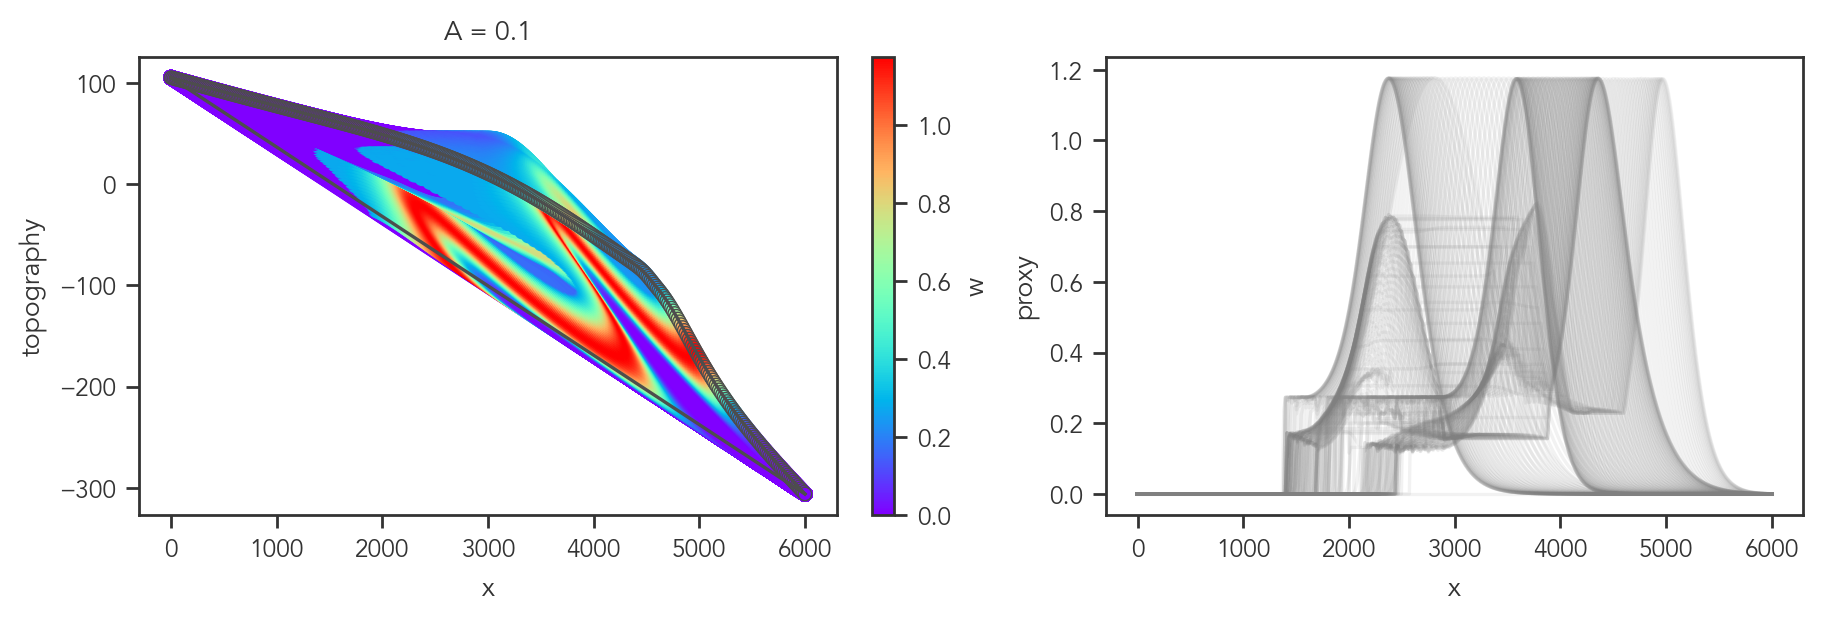

In [10]:
# run model
m1b = run(p1,                            
          model_desc = 'TOCM1b',                
          hi = hi,                            
          wi = wi1,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,           
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,             
          track_toc = True,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          grid_level='compiled', # for lining up sto_prev shape with the time slice for applying new reaction with moles carbon
          swi_dist_calc = True,
          track_react = 'respiration',
          swi_fun = resp_fun)     

im_ylen = 1000 matching grid_ylen


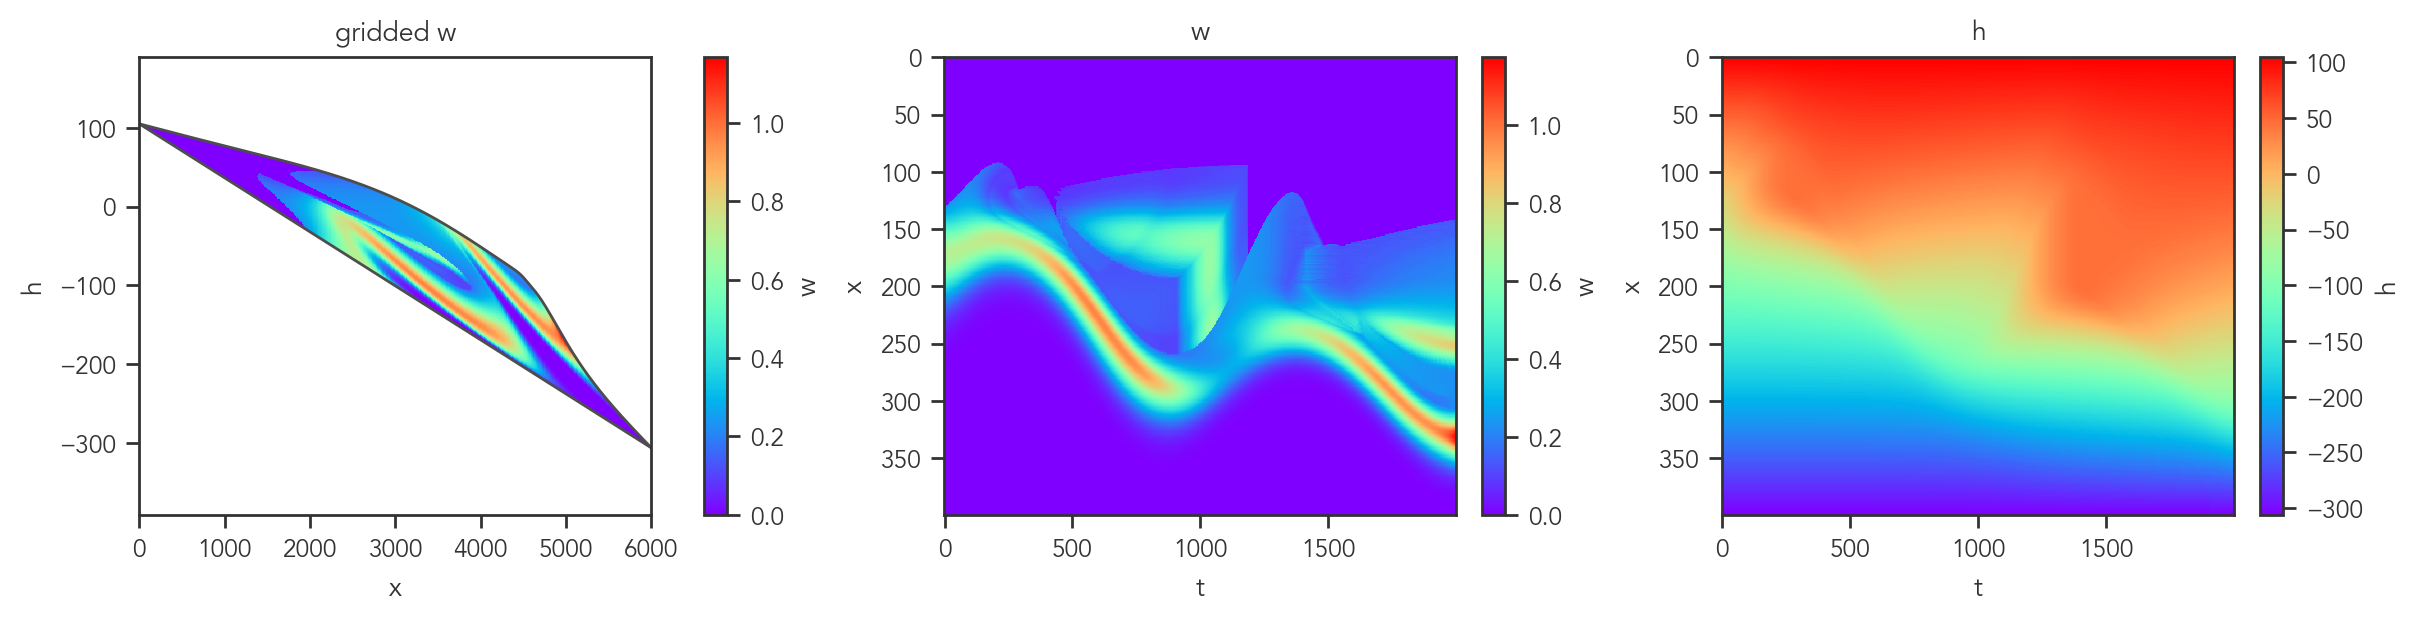

In [11]:
## model outputs
o1b = Model_output(**m1b,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=True)
o1b.plot_grids(cmap='rainbow')

## Determine difference between run 1a and 1b: Converting amount TOC remaining to amount TOC lost

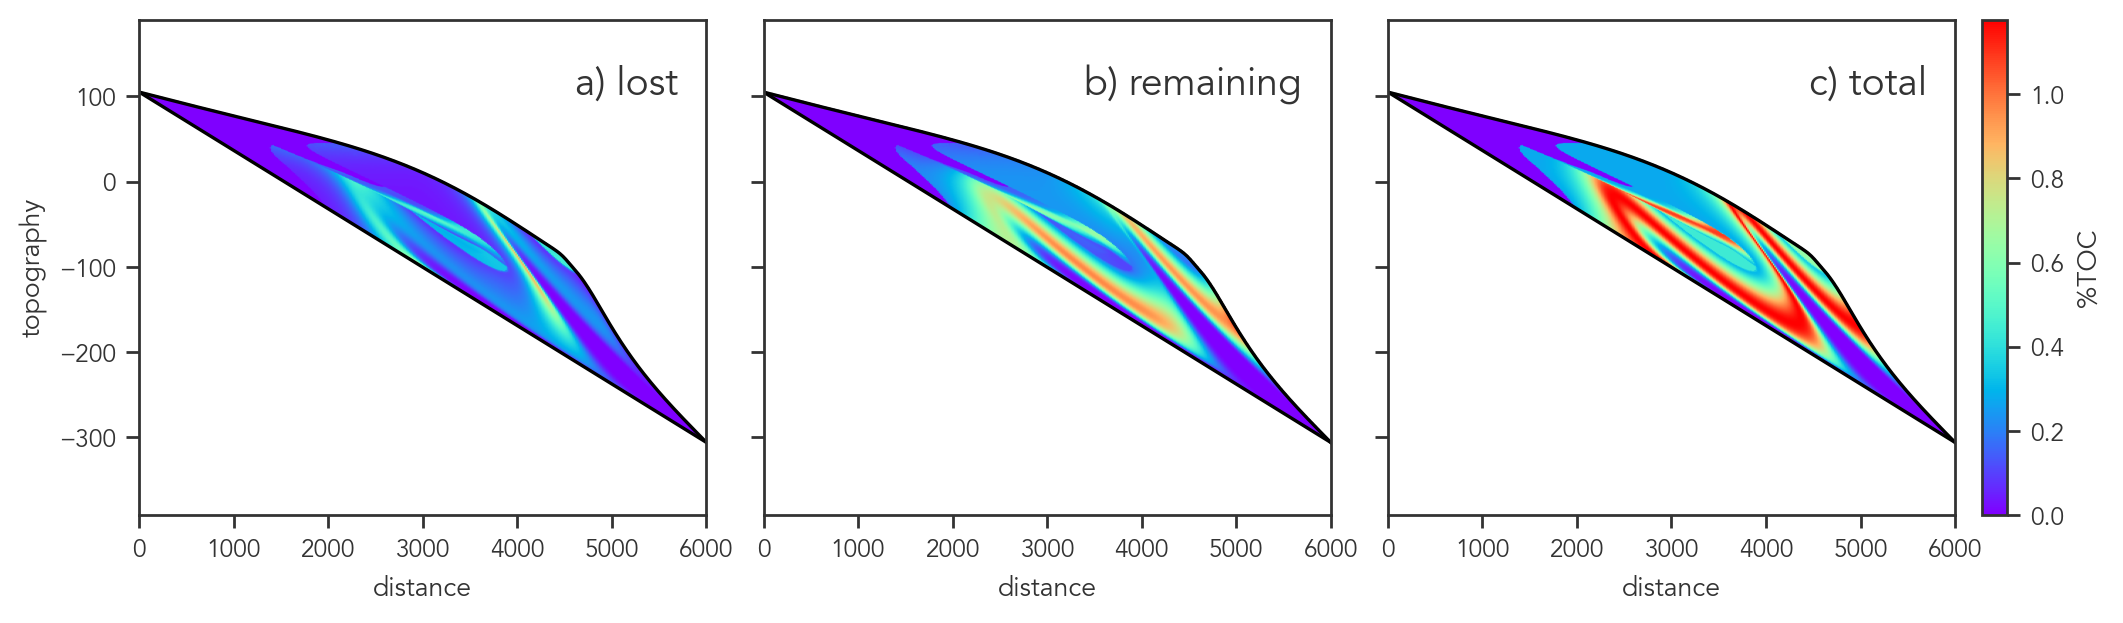

In [12]:
# TOC_loss = no_respiration - with_respiration = a - b
grid_d = o1a.gridw - o1b.gridw
grid_d = np.clip(grid_d, 0, None)            # remove erosion (negative loss)

# stack all three arrays to get global min/max
all_data = np.stack([grid_d, o1b.gridw, o1a.gridw])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

# plot
fig,ax = plt.subplots(1,3,figsize=(10.5,3),sharey=True,layout='constrained')

# lost
im = ax[0].imshow(grid_d,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='%TOC loss to respiration',location='top')
ax[0].plot(x,o1a.beds[0],c='k')
ax[0].plot(x,o1a.beds_eroded[-1],c='k')
ax[0].set_xlabel('distance')
ax[0].set_ylabel('topography')

# remain
im = ax[1].imshow(o1b.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='%TOC remaining after respiration',location='top')
ax[1].plot(x,o1a.beds[0],c='k')
ax[1].plot(x,o1a.beds_eroded[-1],c='k')
ax[1].set_xlabel('distance')

# total
im = ax[2].imshow(o1a.gridw,aspect='auto',origin='upper',cmap='rainbow',extent=o1a.extent,vmin=vmin,vmax=vmax)
#plt.colorbar(im,label='total %TOC without respiration',location='top')
ax[2].plot(x,o1a.beds[0],c='k')
ax[2].plot(x,o1a.beds_eroded[-1],c='k')
ax[2].set_xlabel('distance')

labs = ['a) lost','b) remaining','c) total']
for i,l in enumerate(labs):
    ax[i].text(0.95,0.85,l,transform=ax[i].transAxes,size=14,ha='right')

# shared colorbar on top
cbar = fig.colorbar(im, ax=ax[2], location='right', shrink=1, pad=0, aspect=20)
cbar.set_label('%TOC')

 

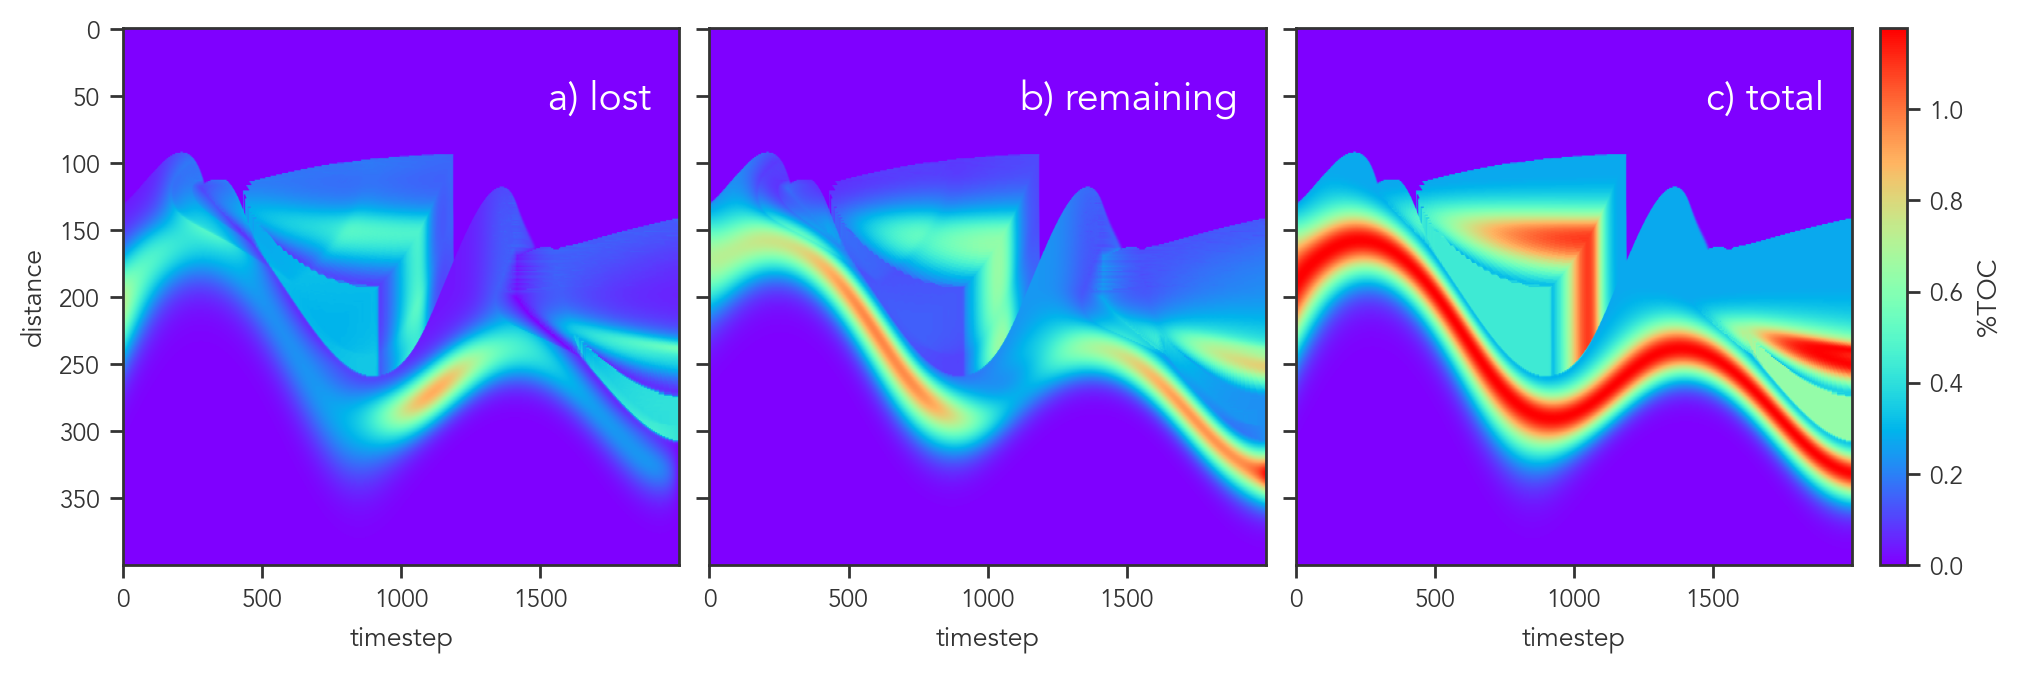

In [13]:
sto_d = o1a.sto[1::2] - o1b.sto[1::2]
sto_d = np.clip(sto_d, 0, None)            # remove erosion (negative loss)

# stack all three arrays to get global min/max
all_data = np.stack([sto_d, o1b.sto[1::2], o1a.sto[1::2]])
vmin = np.nanmin(all_data)
vmax = np.nanmax(all_data)

fig,ax = plt.subplots(1,3,figsize=(10,3.25),sharey=True,layout='constrained')

im = ax[0].imshow(sto_d,aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)
im = ax[1].imshow(o1b.sto[1::2],aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)
im = ax[2].imshow(o1a.sto[1::2],aspect='auto',cmap='rainbow',vmin=vmin,vmax=vmax)

labs = ['a) lost','b) remaining','c) total']
for i,l in enumerate(labs):
    ax[i].text(0.95,0.85,l,transform=ax[i].transAxes,size=14,ha='right',color='w')
    ax[i].set_xlabel('timestep')
ax[0].set_ylabel('distance')

# shared colorbar on top
cbar = fig.colorbar(im, ax=ax[2], location='right', shrink=1, pad=0.05, aspect=20)
cbar.set_label('%TOC')

# clip out left boundaries (not real)
#ax[0].set_ylim(top=120)

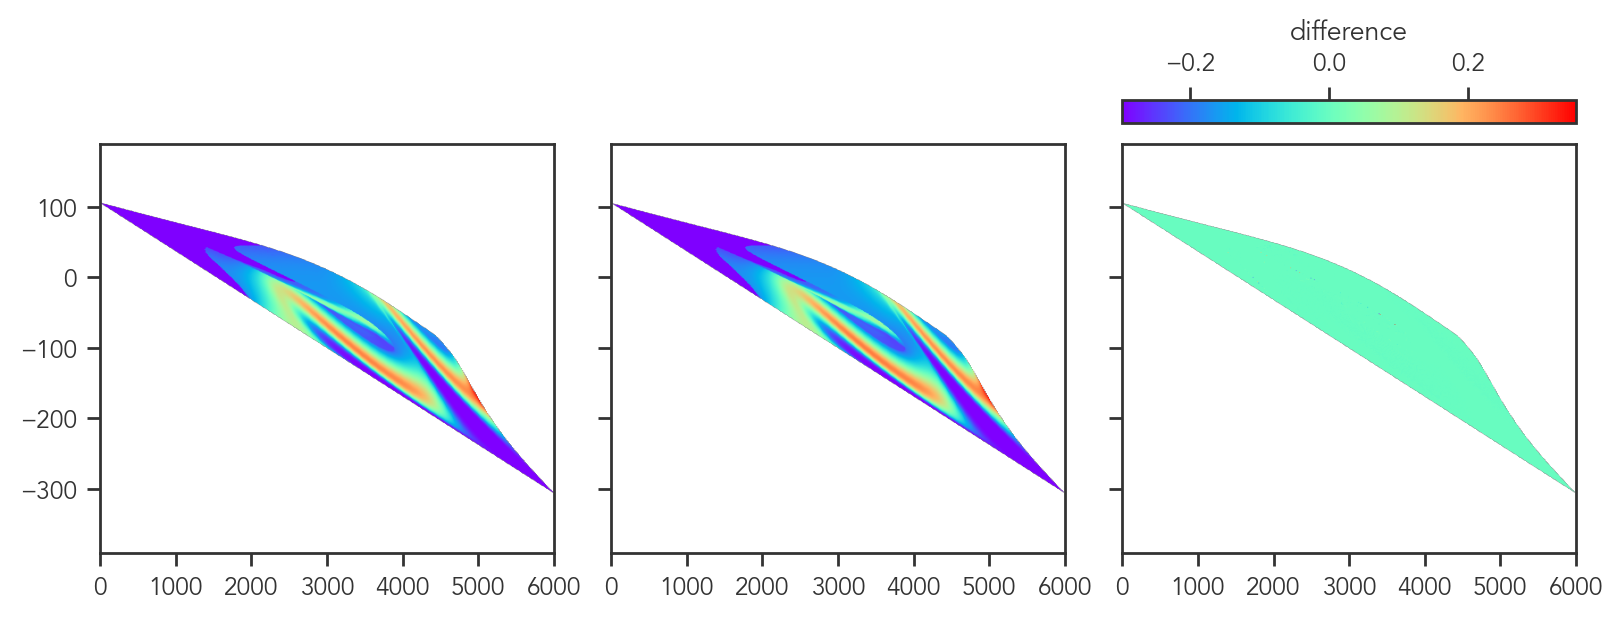

In [14]:
## confirm grid and im_w (sto) are equal
fig,ax = plt.subplots(1,3,figsize=(8,3),layout='constrained',sharey=True)
m = o1b
ax[0].imshow(m.gridw,aspect='auto',extent=m.extent,cmap='rainbow')
ax[1].imshow(np.flipud(m.im_w),aspect='auto',extent=m.extent,cmap='rainbow')
im = ax[2].imshow(m.gridw-np.flipud(m.im_w),aspect='auto',extent=m.extent,cmap='rainbow')
plt.colorbar(im,location='top',label='difference')

In [15]:
print(f'TOC loss model 1: {p1['compiled_steps']}\n{o1b.f_dt*100:.4f}% per dt\n{o1b.f_frac*100:.4f}% per compiled step block')

TOC loss model 1: 100
0.0051% per dt
0.5095% per compiled step block


In [16]:
carb_growth = lambda x: bosscher_G(x,Gm=0.00125,out='growth',Dt=20,k=0.05,Ik=200)
## Rounding is run-dependent!

@interact(idx=(0,1999))
def f(idx):
    rsl = o1a.rsl_strat[idx]
    bed = o1a.beds[idx]
    depth = rsl - bed
    cg = carb_growth(depth)
    og = org_growth(depth)
    ng = og*cg
    plt.plot(o1a.x,cg)
    axi = plt.gca().twinx()
    axi.plot(o1a.x,bed,color='.2')
    axi.axhline(rsl,color='grey',ls=':')
    plt.show()

interactive(children=(IntSlider(value=999, description='idx', max=1999), Output()), _dom_classes=('widget-inte…

## Model 1 Summary:
- $w$ is %TOC ([org]/[total sediment])
- reaction removes TOC as a curve relative to the SWI where more removal happens in more "fresh" TOC near the SWI and less deeper into the sediment column
- **Result:** Map of %TOC loss in sediment

## Scenario Initialization
- demonstrating controls on dic and toc. Want to have a shelf and a slope peak in TOC preserved, with sub environments (shelf to slope transect) for each

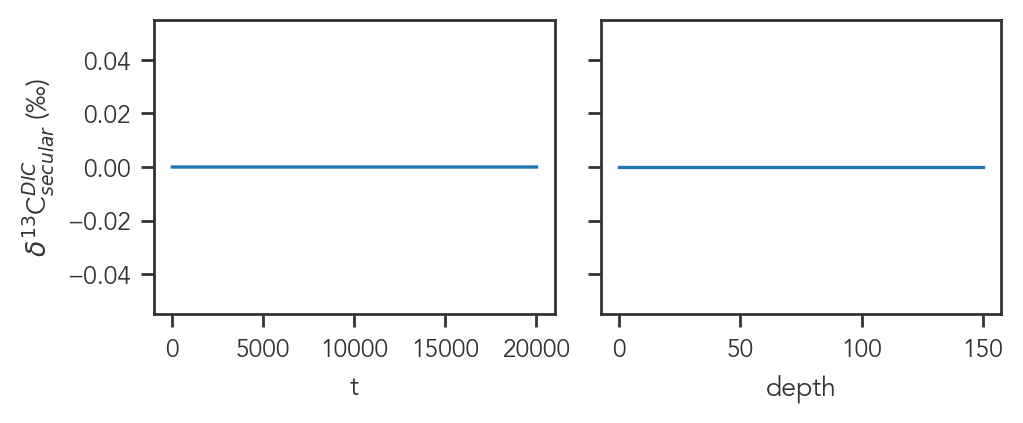

In [17]:
# water depths
z = np.linspace(1e-5,150,1000)

# secular w array - want no change here
seawater = 0 # ‰ d13c_dic
sec_w_fun = lambda t: jnp.ones_like(t) * seawater

fig,ax = plt.subplots(1,2,figsize=(5,2),sharey=True,layout='constrained')

# proxy over time
ax[0].plot(t,sec_w_fun(t))
ax[0].set_ylabel(r'$\delta^{13}$C$_{secular}^{DIC}$ (‰)')
ax[0].set_xlabel('t');

# spatial
depth_w_fun = lambda x: bosscher_G(x,out='growth',Gm=0,G_base=0,k=0.3)#,Ik=750) # can change k for how sharp the gradient is (lower = more gradual); 0.2. 0.4
ax[1].plot(z,depth_w_fun(z))
ax[1].set_xlabel('depth');

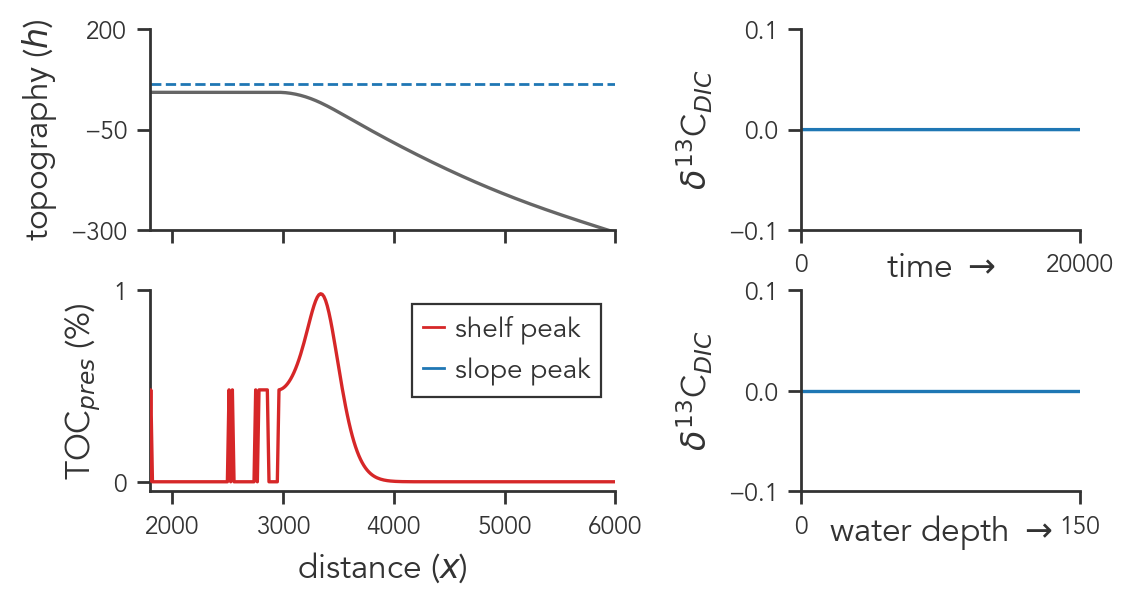

In [18]:
fig,ax = plt.subplot_mosaic(
    """
    aac
    bbd
    """,figsize=(6,3),width_ratios=(1,1,2))

a = list(ax)

# basin snapshot
tidx = 1370 
bed = o1a.beds[tidx]
ax['a'].plot(o1a.x,bed,color='.4')
ax['a'].set_xlim(1800,6000)
ax['a'].set_ylim(-300,200)
ax['a'].set_yticks(np.linspace(-300,200,3))
ax['a'].set_ylabel('topography ($h$)',fontsize=12)
ax['a'].tick_params(axis='x', which='both', bottom=True, labelbottom=False)

# rsl
rsl = o1a.rsl_strat[tidx]
shore = o1b.sl[tidx]
ax['a'].hlines(y=rsl,xmin=shore,xmax=o1a.x[-1],label='rsl',zorder=0,ls='--',lw=1)

# TOC environments
ax['b'].sharex(ax['a'])
ax['b'].set_xlabel('distance ($x$)',fontsize=12)
depth = rsl-bed
depth = np.where(depth>0,depth,np.nan)
og = org_growth(depth)
cg = carb_growth(depth)
ng = og*cg # scale organic by carbonate sedimentation
ax['b'].plot(o1a.x,ng,color='tab:red',zorder=1000)
# axi = ax['b'].twinx()
# axi.plot(x,cg,color='tab:orange')
ax['b'].set_ylabel('TOC$_{pres}$ (%)',fontsize=12)
max_ng = np.nanmax(ng)
rounded_max = round(max_ng * 1e7, 1) * 1e-7  # rounds mantissa to 1 decimal
#ax['b'].set_yticks(np.linspace(0, rounded_max, 3))
ax['b'].set_ylim(top=rounded_max)
ax['b'].set_yticks([0,rounded_max+0.1e-7],[0,1])

# secular
ax['c'].plot(o1b.ts,sec_w_fun(t))
ax['c'].set_ylabel('$\\delta^{13}$C$_{DIC}$',fontsize=12)
ax['c'].set_xlabel('time $\\rightarrow$',labelpad=-10,fontsize=12)
#ax['c'].yaxis.tick_right()  
#ax['c'].xaxis.tick_top()  
#ax['c'].xaxis.set_label_position('top')
#ax['c'].yaxis.set_label_position('right')
ax['c'].set_yticks([-0.1,0,0.1])
ax['c'].set_xlim(0,20000)
ax['c'].set_xticks([0,20000])


# spatial
ax['d'].plot(z,depth_w_fun(z))
ax['d'].set_ylabel('$\\delta^{13}$C$_{DIC}$',fontsize=12)
ax['d'].set_xlabel('water depth $\\rightarrow$',labelpad=-10,fontsize=12)
#ax['d'].yaxis.tick_right()  
#ax['d'].yaxis.set_label_position('right')
ax['d'].set_yticks([-0.1,0,0.1]);
ax['d'].set_xlim(0,np.rint(max(z)))
ax['d'].set_xticks(np.linspace(0,np.rint(max(z)),2))

# format
for i,j in enumerate(a):
    ax[j].spines[['right','top']].set_visible(False)

#format
plt.subplots_adjust(wspace=1,hspace=0.3)
for i in a:
    ax[i].set_facecolor('none')

# legend for TOC scenarios
ha = [
    Line2D([0], [0], mew=0.65, lw=1, marker='none', color='tab:red', ls='-', label='shelf peak', markerfacecolor='none', markersize=0),
    Line2D([0], [0], mew=0.65, lw=1, marker='none', color='tab:blue', ls='-', label='slope peak', markerfacecolor='none', markersize=0)]

ax['b'].legend(handles=ha, loc=1, ncols=1, frameon=True, framealpha=1, fontsize=10,
             handletextpad=0.4, markerfirst=True, handlelength=0.75)

# Model 2: $\delta^{13}C_{carb}$ Alteration: Early diagenetic overprinting with isotopically depleted porefluid
- with same topography as Model 1

## 1) Porefluid Reaction: respired organic matter
- I am wondering if this should just be the same as the respiration amount curve, just rescaled to d13c of sediment and seawater

### Building a Reaction Curve from %TOC Loss maps output from Model 1a and 1b

#### Converting %TOC loss to moles carbon loss

Text(0, 0.5, 'x gridpoint')

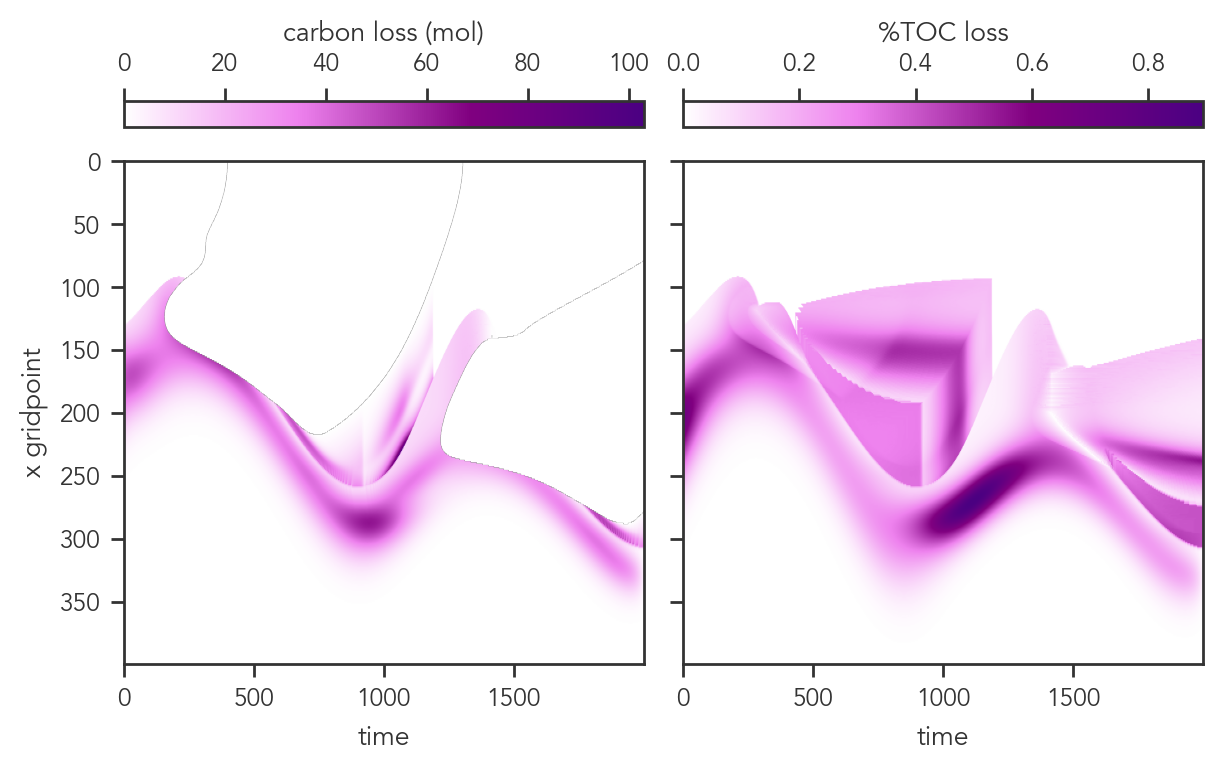

In [52]:
# --- Clean up arrays ---

# extract topography and TOC data
beds_sto = o1b.sto[::2].T          # shape (Nt, Nx)
proxy_sto = sto_d                  # TOC% loss, shape (Nt, Nx)

# mask out eroded beds
beds_sto_eroded = np.minimum.accumulate(beds_sto[::-1, :], axis=0)[::-1, :]
mask_sto = (beds_sto > beds_sto_eroded)
beds_sto_eroded = np.where(mask_sto, np.nan, beds_sto)

# --- Convert TOC% loss to mol C using new generalized function ---
mol_C, v_cm3 = toc_mol(proxy_sto, beds_sto.T, mode='sediment', params=p1,sed_scale=True,frac_reactive=0.5)

# --- Remove eroded beds from mol_C using erosion mask ---
var = o1b.proxy_sto_eroded.T
mol_C = jnp.where(jnp.isnan(var), jnp.nan, mol_C)

# --- Plotting ---

#colors = ['white', 'violet', 'purple', 'black']
colors = ['white', 'violet', 'purple', 'indigo']
purps = sns.blend_palette(colors, as_cmap=True)
purps_r = sns.blend_palette(colors[::-1], as_cmap=True)

fig, ax = plt.subplots(1, 2, figsize=(6, 3.75), sharey=True, sharex=True, layout='constrained')

# mol C loss plot
im1 = ax[0].imshow(mol_C, aspect='auto', cmap=purps)
cb1 = plt.colorbar(im1, ax=ax[0], location='top', label='carbon loss (mol)')

# TOC % loss plot
im2 = ax[1].imshow(proxy_sto, aspect='auto', cmap=purps)
cb2 = plt.colorbar(im2, ax=ax[1], location='top', label='%TOC loss')

[ax[i].set_xlabel('time') for i in range(2)]
ax[0].set_ylabel('x gridpoint')

## Run Model 2

### Porosity profile that matches respiration rate curve (berner)

(-0.05, 1.05)

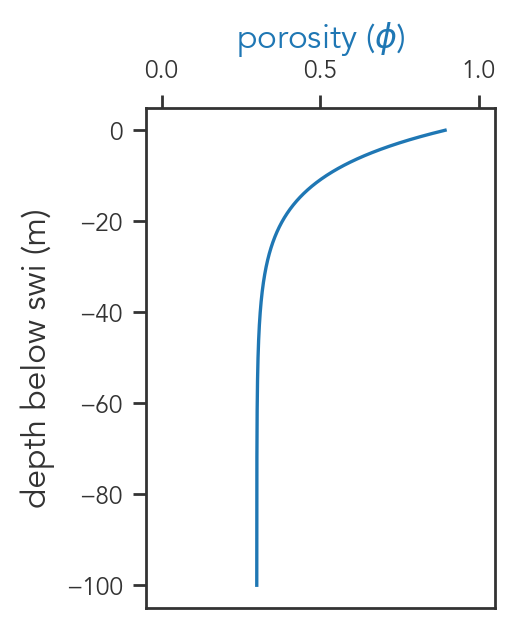

In [53]:
# # --- decay function: blends seawater and sediment signals with exponential weight ---
# def decay_fun(vertical_distance, d13c_seawater=0.0, base_value=1.0, tau=0.1):
#     rxn =  (d13c_seawater * jnp.exp(tau * vertical_distance) + base_value * (1.0 - jnp.exp(tau * vertical_distance)))
#     return rxn

# make porosity profile that matches my respiration curve above (see berner)
def porosity_profile(vertical_distance,norm=False):
    # convert negative vertical_distance to positive depth
    depth = -vertical_distance  # now goes from 0 (swi) to 50 (deep)
    minp = 0.30
    start = 0.10
    # implement the exact published equation
    phi = 0.60 * jnp.exp(-0.10 * depth) + minp
    #phi = 0.60 * jnp.exp(-0.0095 * depth) + 0.30

    # normalize to 0–1
    phi_min = minp
    phi_max = 0.90
    if norm:
        phi_normalized = (phi - phi_min) / (phi_max - phi_min)
    else:
        phi_normalized = phi
    
    return phi_normalized

decay_curve1 = porosity_profile(zs)
#tau = 0.1
#decay_curve2 = decay_fun(zs, d13c_seawater=1.0, base_value=0.0, tau=tau)

fig, ax = plt.subplots(figsize=(2.25, 3.25))
ax.plot(decay_curve1, zs,label='porosity as berner')
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.set_xlabel('porosity ($\\phi$)',fontsize=12,color='tab:blue')
ax.set_ylabel('depth below swi (m)',fontsize=12)
ax.set_xlim(-0.05,1.05)
# axi = ax.twiny()
# axi.plot(decay_curve2, zs,label='respiration without lower limit',ls='--',color='tab:orange')
# axi.set_xlabel('decay',color='tab:orange')

## Re-initialize as d13c instead of TOC

R = 0.00001054


Text(0.5, 0, 't')

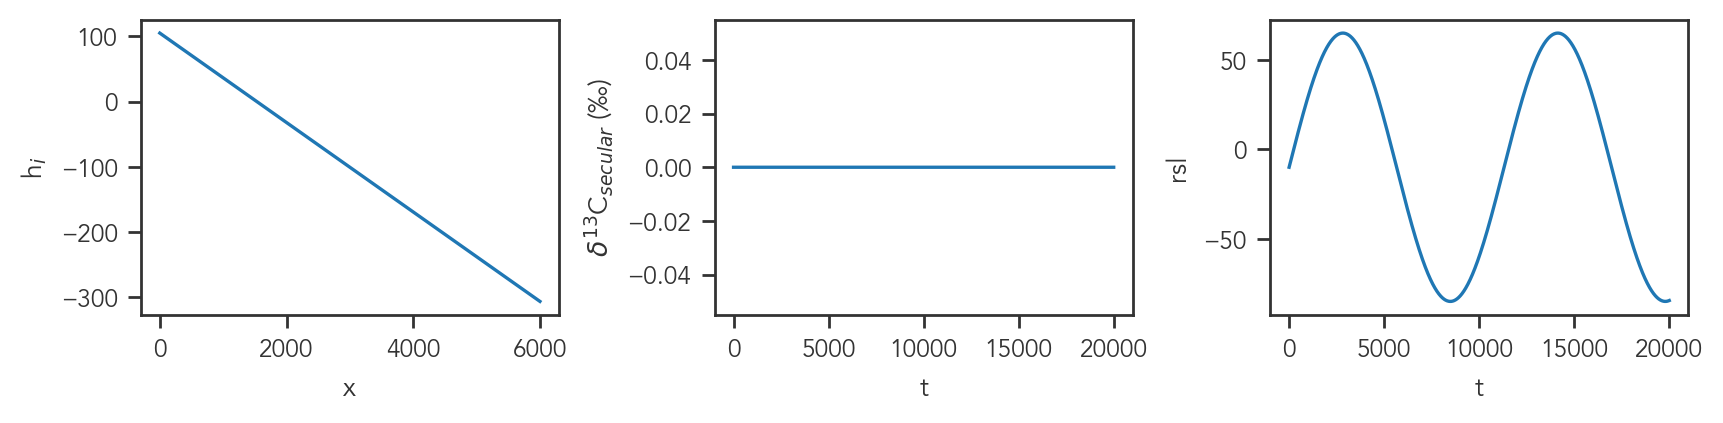

In [54]:
# modify params as needed
p2 = p1.copy()
trg2 = 10 # % / Myr
R = compute_f_react(trg2, p2['dt']) # 10%/Myr
print(f'R = {R:.8f}')

p2['f_react'] = R #0.01 # react 1% of sediment with porefluid per dt (not compiled step)
#p2['f_react'] = 0.00001 # react 1% of sediment with porefluid per dt (not compiled step)
#p2['f_react'] = 1.425e-5
p2['alg_epsilon'] = 0 # carbonates growing at 3‰

# secular w array - want no change here
seawater = 0 # ‰ d13c dic
sec_w_fun = lambda t: jnp.ones_like(t) * seawater

## Define h: initial topographic composition
hi = -0.0685*x+105

fig,ax = plt.subplots(1,3,figsize=(8.5,2),layout='constrained')

# initial proxy and topography
ax[0].plot(x,hi,label='h$_i$')
ax[0].set_xlabel('x')
ax[0].set_ylabel('h$_i$')

# proxy over time
ax[1].plot(t,sec_w_fun(t))
ax[1].set_ylabel(r'$\delta^{13}$C$_{secular}$ (‰)')
ax[1].set_xlabel('t');

# sea level
#sl_fun = lambda t: 75*jnp.sin((t)/1800)-10 # from EPSL paper

ax[2].plot(t,sl_fun(t))
ax[2].set_ylabel('rsl')
ax[2].set_xlabel('t')

In [55]:
# change initial conditions to reflect d13c instead of [TOC]
wi2 = jnp.ones_like(hi)*0.0

calculated ymin,ymax = -391.00, 190.00
mean grid dy = 5.816e-01


running model: TOCM2_A0.1_ylen1000_2025-07-24 11:30:   0%|          | 0/2000 [00:00<?, ? compiled steps/s]

plotting results:   0%|          | 0/2000 [00:00<?, ? beds/s]

actual ymin,ymax = -306.00, 105.00
mean eroded distance = 1.72e-01; mean deposited distance = 5.57e-02


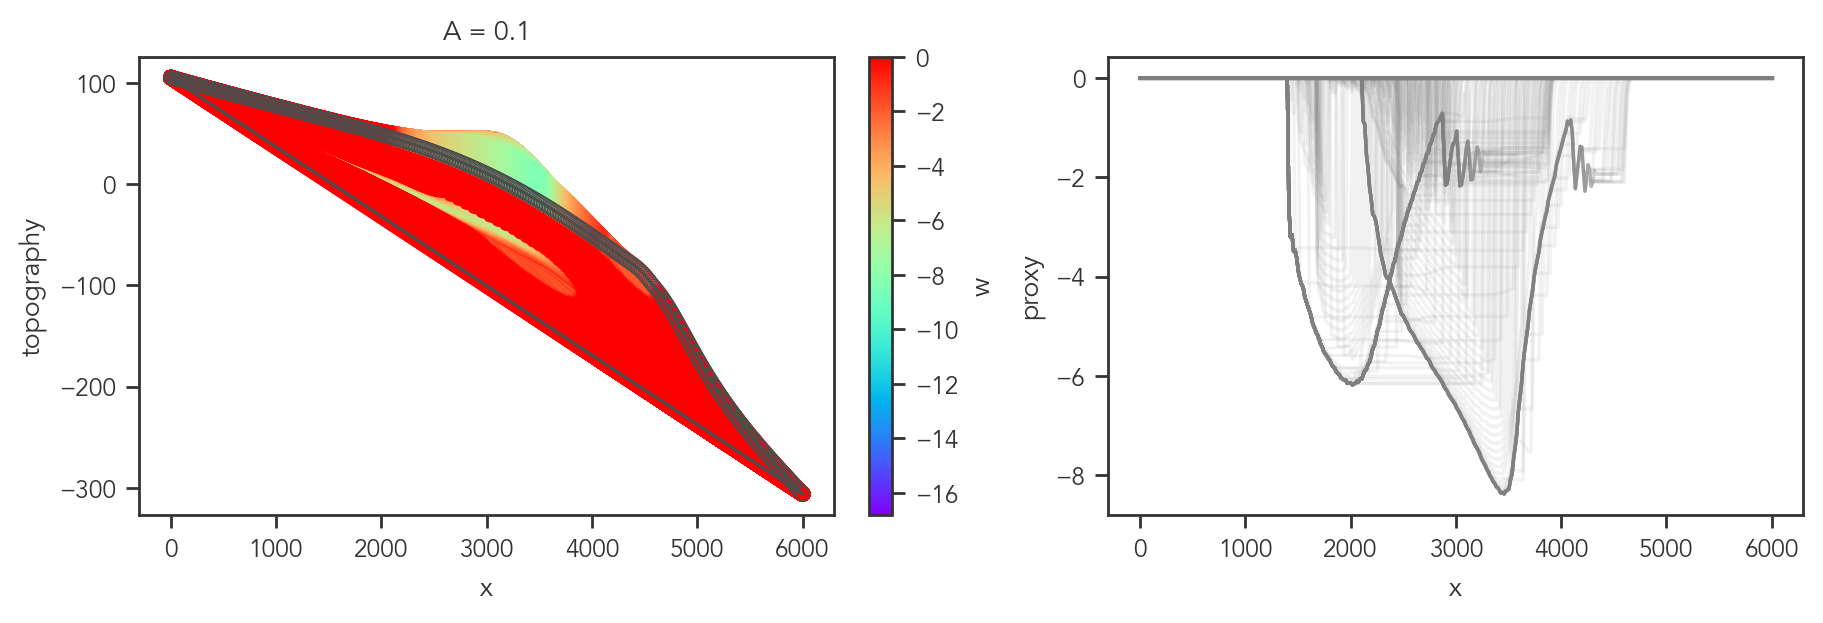

In [56]:
# run model; run time with erosion around 12 minutes
m2 = run(p2,                            
          model_desc = 'TOCM2',                
          hi = hi,                            
          wi = wi2,                            
          sl_fun = sl_fun,                   
          sec_w_fun = sec_w_fun,           
          wi_sec = False,
          depth_w_fun = None,  
          carb_growth=True,
          org_growth=True,
          growth_fun_alg = carb_growth,     
          growth_fun_org = org_growth,                  
          track_toc = False,
          scale_organics=scale_organics,
          w_set_erode = True,              
          full_storage = True,  
          storage_level = 'compiled',
          grid_level = 'compiled',
          swi_dist_calc = True,
          track_react = 'molar',
          swi_fun = None,
          porosity_fun = porosity_profile,
          sto_prev = mol_C) # feed in respired moles of carbon from previous runs

im_ylen = 1000 matching grid_ylen


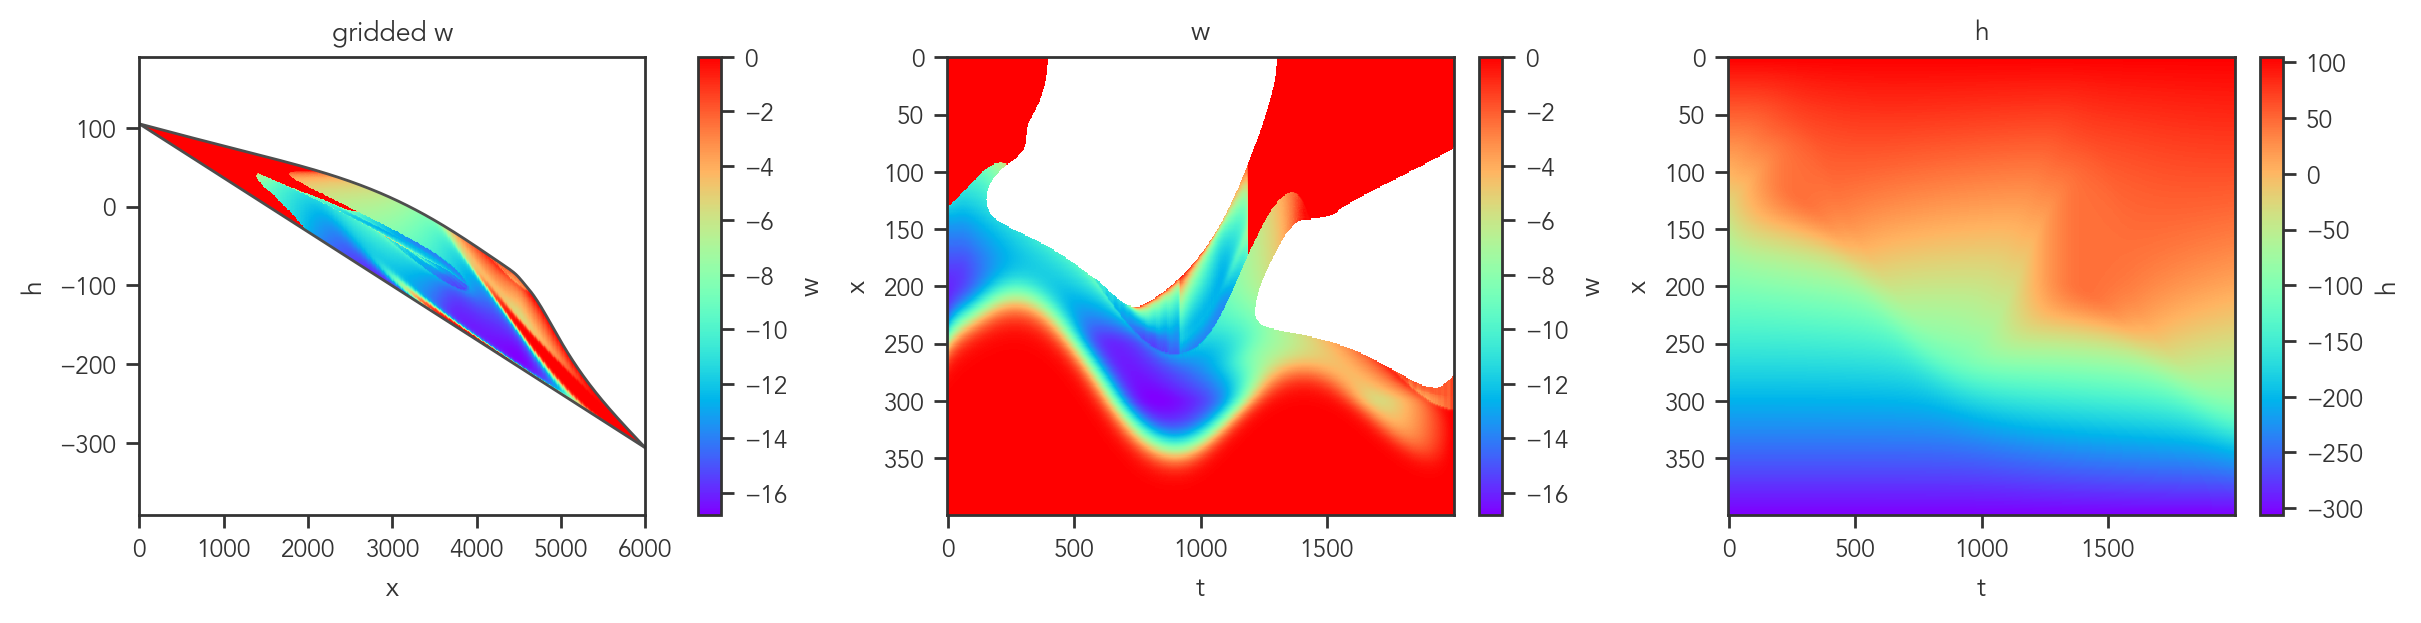

In [57]:
## model outputs
o2 = Model_output(**m2,facies_data=facies_data,facies_colours=facies_colours,bc_filter=False,set_under_c='.3',im_ylen=None,images=True,swi_dist_calc=True)
o2.plot_grids(cmap='rainbow')

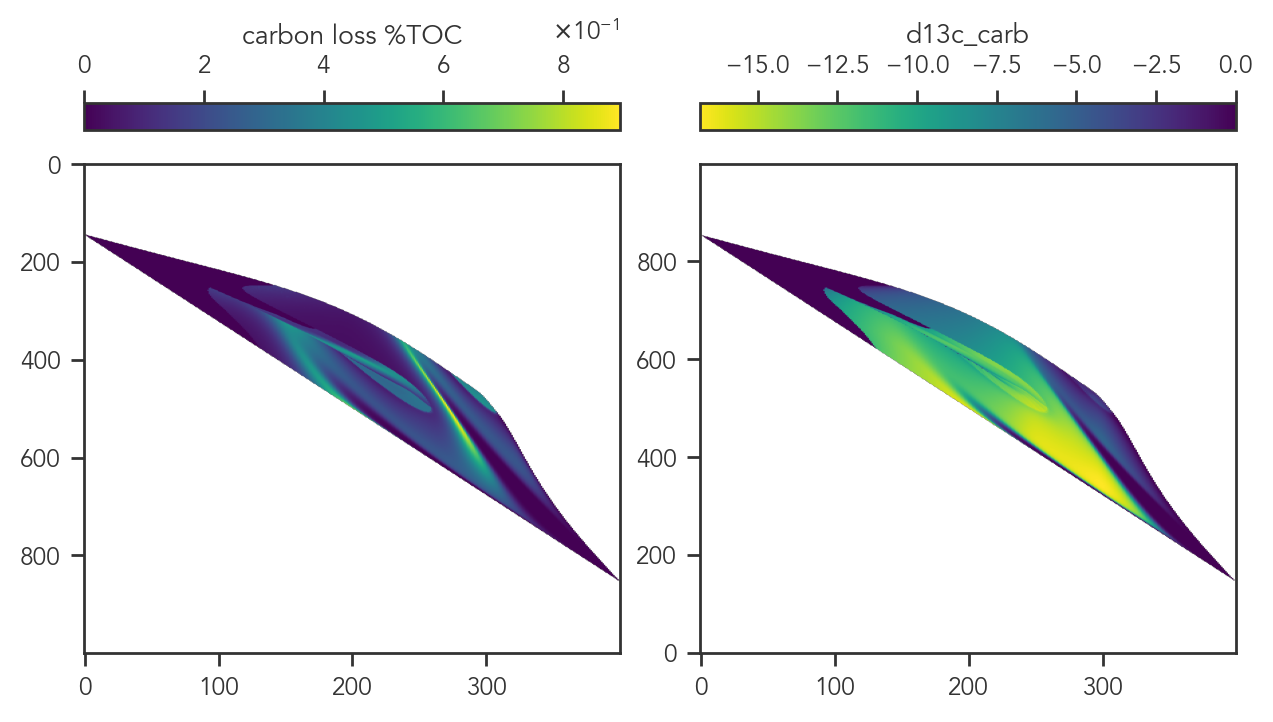

In [59]:
fig,ax = plt.subplots(1,2,figsize=(6.25,3.5),layout='constrained')

im1 = ax[0].imshow(grid_d,aspect='auto')
cb1 = plt.colorbar(im1,ax=ax[0],location='top',label='carbon loss %TOC')
cb1.ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb1.ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

im2 = ax[1].imshow(o2.im_w,aspect='auto',cmap='viridis_r',origin='lower')
cb2 = plt.colorbar(im2,ax=ax[1],location='top',label='d13c_carb')
cb2.ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))


In [60]:
@interact(idx=(1,399))
def f(idx):
    fig,ax = plt.subplots(1,2,figsize=(5.25,4.5),layout='constrained',width_ratios=[1,0.5])
    
    im = ax[0].imshow(o2.im_w,aspect='auto',cmap='viridis_r',origin='lower')
    #im = ax[0].imshow(o2.facies_pred,aspect='auto',cmap=o2.cmap,origin='lower')
    cb = plt.colorbar(im,ax=ax[0],location='top',label='d13c_carb')
    cb.ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    toc = grid_d[:,idx]
    carb = np.flipud(o2.im_w[:,idx])
    ax[0].axvline(idx,color='tab:orange',ls='--')
    ax[1].plot(carb,np.arange(len(carb)),label='carb')
    ax[1].set_xlabel('d13c_carb',color='tab:blue')
    ax1 = ax[1].twiny()
    ax1.plot(toc,np.arange(len(toc)),label='toc',color='tab:red',ls=':')
    ax1.set_xlabel('%toc loss',color='tab:red')
    ax1.set_xlim(-0.05,1)
    ax[1].set_xlim(p2['ep'],1)
    ax[1].set_xticks(np.linspace(p2['ep'],1,3))
    ax[1].invert_yaxis()
    plt.show()

interactive(children=(IntSlider(value=200, description='idx', max=399, min=1), Output()), _dom_classes=('widge…

# Figures

### 1) TOC loss vs d13c_carb

In [47]:
# # --- prepare data ---
# toc = np.where(grid_d > 0, grid_d, np.nan).ravel()    
# carb = np.flipud(o2.im_w).ravel()                            
# carb = np.where(carb < -1e-2, carb, np.nan)
# # toc = rem_ol(toc)
# # carb = rem_ol(carb)

# # --- fit curve ---
# # remove nans before fitting
# # mask = (~np.isnan(toc)) & (~np.isnan(carb))
# # x_fit = toc[mask]
# # y_fit = carb[mask]

# # # define exponential decay model: y = a * exp(-b * x) + c
# # def exp_decay(x, a, b, c):
# #     return a * np.exp(-b * x) + c

# # # use curve_fit to fit the model to data
# # popt, _ = curve_fit(exp_decay, x_fit, y_fit, p0=[-14, 5, 0])  # initial guess

# # evaluate the fit for plotting
# # x_smooth = np.linspace(np.nanmin(toc), np.nanmax(toc), 500)
# # y_smooth = exp_decay(x_smooth, *popt)

# # --- plot ---
# #fig, ax = plt.subplots(figsize=(5.25, 4))
# fig, ax = plt.subplots(figsize=(3.25, 2.5))

# ax.grid(zorder=0, ls='-')
# # gridsize 40 for larger plot
# hb = ax.hexbin(toc, carb, gridsize=20, cmap=purps, mincnt=1, zorder=1000, clip_on=False,alpha=1,edgecolor='.4',lw=0.75,vmin=0,vmax=2.5e3)
# cb = fig.colorbar(hb, ax=ax)
# cb.set_label('count')
# cb.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# cb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

# # overlay fit
# # ax.plot(x_smooth, y_smooth, color='red', lw=1.75, label=f'exponential fit:\ny = {popt[0]:.1f} $e^{{{{{popt[1]:.1f}}}x}}$ + {popt[2]:.1f}', zorder=1001,ls='--')
# # #ax.legend(handlelength=.75)

# # labels and limits
# ax.set_xlabel('$TOC_{loss}$ (%)')
# ax.set_ylabel('$\\delta^{13}$C$_{carb}$ (‰)')
# #ax.set_ylim(-15, 0)
# # ax.set_xlim(-0.025, 0.9)
# print(f"Fit params: a={popt[0]:.2f}, b={popt[1]:.2f}, c={popt[2]:.2f}")
# ax.tick_params(axis='both', which='major', length=0)


# # --- Save ---
# fig.savefig(fig_dir + 'd13c_vs_tocloss.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

### 2) Carbonate sedimentation (carb) vs preserved TOC
- rate = qh_carb/dt
- did a test with no tidal depth Dt and no forced organic/carbonate scaling, and the positive correaltion still persists, but only for very low carbonate sedimentation rates, as they incrsease, the correlation becomes anticorrelated

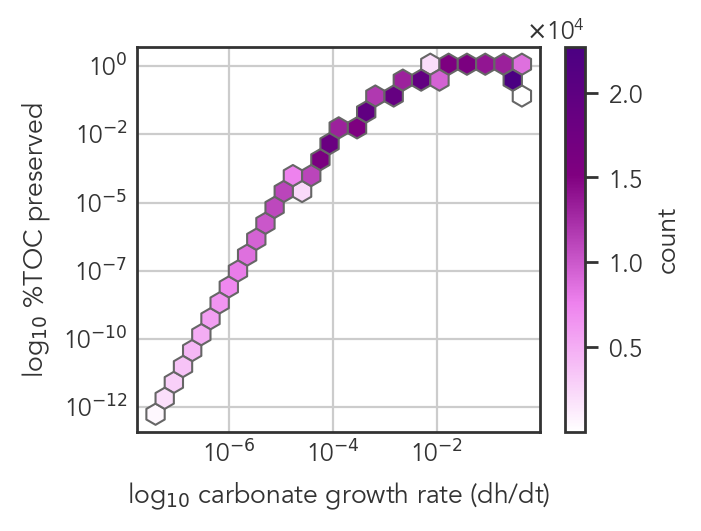

In [48]:
# --- extract variables ---
eroded = np.isnan(o2.proxy_sto_eroded.T)
topo = o1a.sto[::2]            # topography (Nx, Nt)
toc = o1a.sto[1::2]            # TOC% preserved (Nx, Nt)

# remove eroded values
topo = np.where(eroded, np.nan, topo)
toc = np.where(eroded, np.nan, toc)
rate = o2.csed_sto / p1['dt']
rate = np.where(eroded, np.nan, rate)

# mask negative or invalid values
rate = np.where((toc >= 0) & (rate >= 0), rate, np.nan)
toc = np.where((toc >= 0) & (rate >= 0), toc, np.nan)

# --- plotting ---
#fig, ax = plt.subplots(figsize=(5.25, 4))
fig, ax = plt.subplots(figsize=(3.25, 2.5))

ax.grid(zorder=0, ls='-')

# --- crossplot: flatten and filter ---
toc = np.where(toc>0,toc,np.nan)
min_rate = 0 # 1e-5
rate = np.where(rate>min_rate,rate,np.nan) # filter out very small rates
toc_flat = toc.flatten()
rate_flat = rate.flatten()
mask = (~np.isnan(toc_flat)) & (~np.isnan(rate_flat))
toc_flat = toc_flat[mask]
rate_flat = rate_flat[mask]

# --- crossplot ---
# gridsize 40 for larger plot
hb = ax.hexbin(np.log10(rate_flat), np.log10(toc_flat), gridsize=20,clip_on=False,alpha=1,edgecolor='.4',lw=0.75, cmap=purps, mincnt=1,zorder=100)
#hb = ax.hexbin(rate_flat, toc_flat, gridsize=40,clip_on=False,alpha=1,edgecolor='.4',lw=0.75, cmap=purps, mincnt=1,vmax=10000,zorder=100)
cb = plt.colorbar(hb, ax=ax, label='count')
cb.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb.ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_xlabel('log$_{10}$ carbonate growth rate (dh/dt)')
ax.set_ylabel('log$_{10}$ %TOC preserved')

# label ticks for log scale
def plain_power_format(x, _):
    return f'10$^{{{int(x)}}}$'

ax.xaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(plain_power_format))

# set lims
# ax.set_ylim(-13,0.35)
# ax.set_xlim(-8.5,-1.25)
ax.tick_params(axis='both', which='major', length=0, direction='out')
fig.savefig(fig_dir + 'carb_rate_vs_toc.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

## Summary Figure for TOC to $\delta^{13}$C$_{carb}$ pipeline

### Significant sensitive variables
1. Rate of TOC loss per dt due to respiration (find reference)
2. Fraction sediment reacted with porefluid per dt (find reference)

### Assumptions
1) TOC preservation scales with carbonate sedimentation rate
2) Respiration rates below the SWI are scaled by porosity
3) Within porefluid, below SWI, surrounding rock is unreactive and only carbon balance is between organic carbon from respiration, and seawater (in porespaces)
4) Organic matter (TOC) is 100% carbon

### Possible things to add
1) Rayleigh fractionation of remaining DOC reservoir

### Demonstration figure with mock data for toc profile and volumes (illustrative, for supplement)

In [49]:
# --- Resample valid profile across depth ---
def resample_valid(var, target_zs, flip=True):
    valid = (~np.isnan(var)) & (var > 0)
    var_valid = var[valid]
    if len(var_valid) < 2:
        return np.full_like(target_zs, np.nan)
    zs_valid = np.linspace(0, dmin, len(var_valid))
    interp_func = interp1d(zs_valid, var_valid, bounds_error=False, fill_value=np.nan)
    resampled = interp_func(target_zs)
    return np.flipud(resampled) if flip else resampled


  0%|          | 0/1998 [00:00<?, ?it/s]

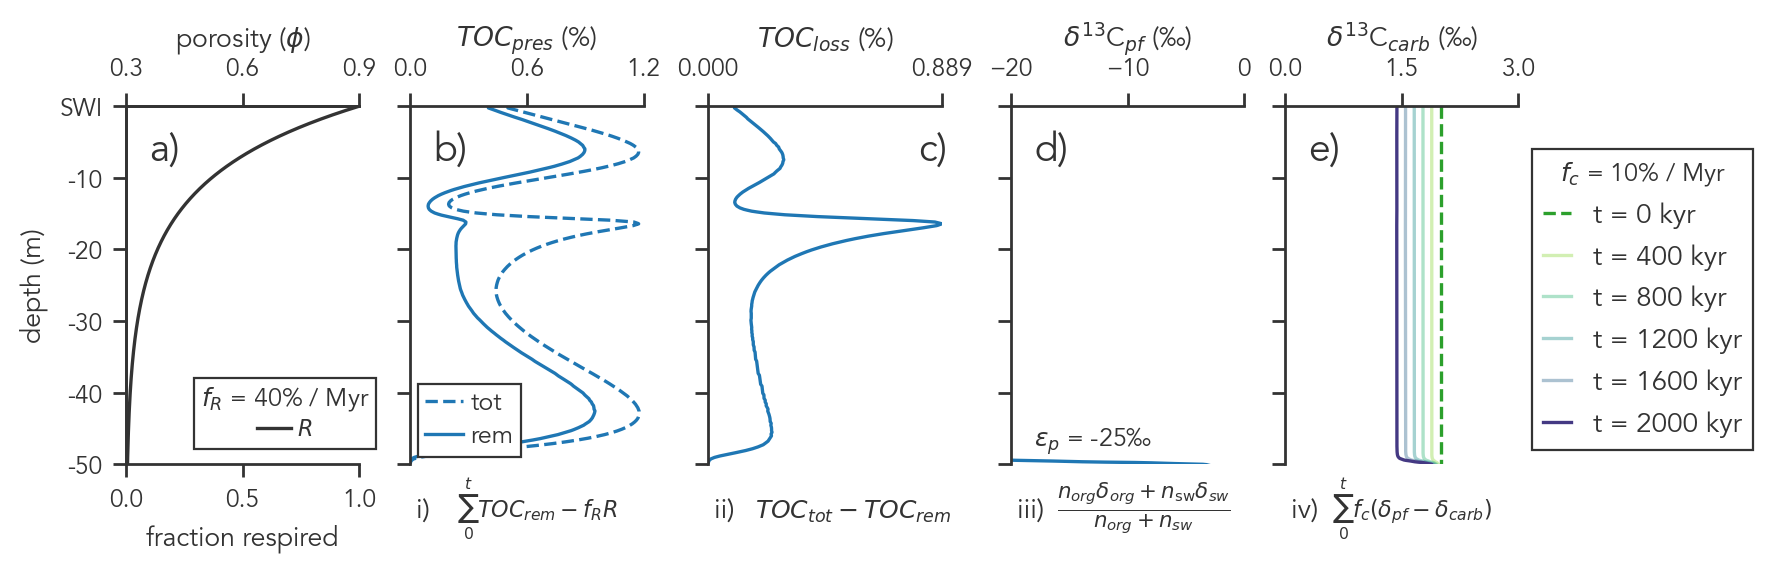

In [50]:
# --- Setup ---
sns.set_context('paper')
zs = np.arange(-100, 0, 0.1)  # depth profile from -100 to 0 meters
porosity = porosity_profile(zs, norm=False)
respiration = resp_fun(zs, tau=p1['tau'], f_react=p1['f_react'])

# --- Constants ---
dmin = -50.5  # minimum depth for plotting; made slightly different than ylim so that i cut off an ugly blip
xidx = 267  # example transect index
zs2 = np.linspace(0, dmin, len(zs))  # target depth axis

# --- Compute mol_C for sediment and seawater ---
tot_toc = resample_valid(np.flipud(o1a.gridw[:, xidx]), zs2)
loss = resample_valid(np.flipud(grid_d[:, xidx]), zs2)
frac_loss = loss/resample_valid(np.flipud(o1a.gridw[:,xidx]),zs2)

phi = np.clip(porosity, 0, 1)

mol_sed, _ = toc_mol(loss, topo=np.zeros_like(loss), dz=1.0, mode='sediment', params=p1)
mol_sw, _ = toc_mol(phi, topo=np.zeros_like(phi), dz = 1.0, mode='seawater', params=p1, phi=phi)

# --- δ13C of porefluid ---
n_org = mol_sed
n_sw = mol_sw
d13c_org = -25.0
d13c_sw = 0.0
resp_value = n_org * d13c_org 
sw_value = n_sw * d13c_sw 
total_mol = n_org + n_sw + 1e-12
d13c_pf = (resp_value + sw_value) / total_mol

# --- Plotting setup ---
fig, ax = plt.subplots(1, 5, figsize=(8.75, 2.75), sharey=True, layout='constrained')

# --- a) Porosity and respiration ---
axp = ax[0].twiny()
axp.spines[['right']].set_visible(False)
axp.set_xlabel('porosity ($\\phi$)')
axp.plot(porosity, zs, label='$\\phi$', color='none', ls='--')
axp.set_xticks(np.linspace(0.3,0.9,3))
axp.set_xlim(0.3,0.9)
ax[0].plot(respiration, zs, label='$R$', color='.2')
ax[0].set(xlabel='fraction respired', ylabel='depth (m)', ylim=(-50, 0), xlim=(0, 1))
ax[0].legend(loc='lower right',bbox_to_anchor=(1.1,0.025),fontsize=8,framealpha=1,handlelength=1.5,handletextpad=0.3,borderpad=0.3,labelspacing=0.25,borderaxespad=0.3,
    frameon=True,title=f'$f_R$ = {trg1:.0f}% / Myr',title_fontsize=9)

# replace 0m with swi label
yticks = ax[0].get_yticks()
yticklabels = [f'{int(t)}' if t != 0 else 'SWI' for t in yticks]
ax[0].set_yticks(yticks) # needs to be here to suppress warning
ax[0].set_yticklabels(yticklabels)

# Format shared properties
for i in range(len(ax)):
    if i>0:
        ax[i].xaxis.set_ticks_position('top')
        ax[i].xaxis.set_label_position('top')
    ax[i].spines[['right', 'bottom']].set_visible(False)

# --- b) Total TOC preserved ---
rem_toc = resample_valid(np.flipud(o1b.gridw[:, xidx]), zs2)
ax[1].plot(tot_toc, zs2, color='tab:blue', ls='--',label='tot')
ax[1].plot(rem_toc, zs2, color='tab:blue', ls='-', label='rem')
ax[1].set(xlabel='$TOC_{pres}$ (%)', xlim=(0, max(np.concat([tot_toc,rem_toc]))), xticks=np.linspace(0, 1.2, 3))
ax[1].legend(loc=3, handlelength=1.5,fontsize=9,handletextpad=0.3,borderpad=0.3,labelspacing=0.25,borderaxespad=0.3)

# --- c) TOC loss ---
ax[2].plot(loss, zs2, color='tab:blue')
ax[2].set(xlabel='$TOC_{loss}$ (%)', xlim=(0, max(loss)))
ax[2].set_xticks(np.linspace(0,max(loss),2))
# axi = ax[2].twiny()
# axi.plot(frac_loss,zs2)

# --- d) δ13C of porefluid ---
ax[3].plot(d13c_pf, zs2, color='tab:blue')
ax[3].set(xlabel='$\\delta^{13}$C$_{pf}$ (‰)', xlim=(-20, 0))

# --- e) δ13C of carbonate (with reaction) ---
f_react = p2['f_react']  # fraction reacted per model step
d13c_sed_val = 2.0
d13c_sed = np.ones_like(zs2) * d13c_sed_val  # initial δ13C of carbonate
# skip = 20000
# start = 1000
# end = 100000
skip = 400
start = 2
end = 2000

n_total = p2['total_n'] * p2['compiled_steps']
# dt_Myr = total_geo_duration_Myr / n_total
# R = f_react / dt_Myr
# percent_per_Myr = 100 * (1 - np.exp(-R))  # effective reaction % per Myr

set_cycler(ax[4], (end // skip), cmap='viridis_r')
ax[4].plot(d13c_sed, zs2, label='t = 0 kyr', color='tab:green', ls='--')

for r in tqdm(range(start, end)):
    delta = f_react * (d13c_pf - d13c_sed)
    d13c_sed += delta

    if r % skip == 0:
        t_myr = r #(r / n_total) #* total_geo_duration_Myr
        ax[4].plot(d13c_sed, zs2, label=f't = {t_myr:.0f} kyr', alpha=0.4, ls='-')

    if r == end - 1:
        t_myr = r + 1 # ((r + 1) / n_total) #* total_geo_duration_Myr
        ax[4].plot(d13c_sed, zs2, label=f't = {t_myr:.0f} kyr', alpha=1)

ax[4].set(
    xlabel='$\\delta^{13}$C$_{carb}$ (‰)',
    xlim=(np.floor(np.min(d13c_sed)) - 1, d13c_sed_val),
    xticks=np.linspace(np.floor(np.min(d13c_sed)) - 1, d13c_sed_val + 1, 3)
)

ax[4].legend(
    loc=3, bbox_to_anchor=(1, 0), handlelength=1, fontsize=10,
    title=f'$f_c$ = {trg2:.0f}% / Myr', # \n({percent_per_Myr:.1f}% / Myr)
    title_fontsize=9
)
# --- Add subplot labels ---
labels = ['a)', 'b)', 'c)', 'd)', 'e)']
for i, label in enumerate(labels):
    xi = 0.1 if i != 2 else 0.9
    ax[i].text(xi, 0.85, label, transform=ax[i].transAxes, fontsize=14)

# label method equations|
ax[1].text(0.2,-0.15,'$\\sum^t_0{TOC_{rem} - f_RR}$',transform=ax[1].transAxes,fontsize=8)
ax[2].text(0.2,-0.15,'$TOC_{tot} - TOC_{rem}$ ',transform=ax[2].transAxes,fontsize=9)
ax[3].text(0.2,-0.15,r'$\frac{n_{org} \delta_{org} + n_{\mathrm{sw}}\delta_{sw}}{n_{org} + n_{sw}}$',transform=ax[3].transAxes,fontsize=11)
ax[4].text(0.2,-0.15,'$\\sum^t_0{f_c(\\delta_{pf} - \\delta_{carb})}$',transform=ax[4].transAxes,fontsize=8)

# number equations
eq_labs = ['i)','ii)','iii)','iv)']
for i,l in enumerate(eq_labs):
    i+=1
    ax[i].text(0.025,-0.15,l,transform=ax[i].transAxes,fontsize=10)

# label ep
ax[3].text(0.1,0.05,f'$\\epsilon_{{p}}$ = {p2['ep']}‰',transform=ax[3].transAxes,fontsize=9)

# --- Save ---
fig.savefig(tex_fig_dir + 'method_demo.pdf', format='pdf', dpi=600, bbox_inches='tight', transparent=True)

# Unit Scaling

## Compiled step scaling f_react
- If f_react is the fraction reacted per timestep (e.g., 0.01 for 1%), and you’re running compiled_steps (e.g., 100) timesteps in one compiled chunk, you scale it as effective_f = 1 - (1 - f_react) ** compiled_steps. This captures the compounding effect — for example, a 1% per-step reaction over 100 steps gives an effective ~63% reaction (1 - 0.99^100 ≈ 0.634). This scaling ensures the net result over 100 steps is equivalent to applying 1% loss repeatedly each step.